# Section III. MOTION PLANNING
    
# Chapter 11. Planning With Dynamics and Uncertainty

<style>
div.figcaption {    
    text-align: center;
    margin-left:1em;
    margin-top:1em;
    margin-right:1em;
    margin-bottom:1em;
    }
</style>

In the preceding discussion on kinematic path planning, we have not yet described how the computed paths could be followed.  In some cases, following a path is simple.  Suppose the robot could move forward and turn in place (e.g., a mobile robot with differential drive such as the iRobot Roomba, or a skid steer) any 2D polygonal path could be followed by a sequence of forward motions and turns. This strategy could also be followed by humanoid robots navigating indoors, simply by stepping along straight lines, turning in place when needed.  Similarly, there exist techniques for industrial robot arms to follow configuration-space paths created by sampling-based planners, as long as they do not move too quickly.

In more general cases, however, kinematic planning is not appropriate.  This chapter will discuss two issues that cannot be handled in the basic planning formulation described thus far, and require significant extensions to the basic discretize-and-search paradigm:

**Kinodynamic planning**.  In kinodynamic planning, the robot cannot simply move the state of the world in any direction it pleases.  Instead, it must also model the dynamics of the particular system.  Kinodynamic planning can also account for time-varying goals / costs and moving obstacles.  A related concept is known as _nonholonomic_ planning, which does not involve dynamics per se but also involves constraints on the derivative of the path.

**Planning with uncertainty**. In many robotics applications, such as avoiding moving obstacles, a robot must integrate new information (feedback) from sensors and respond by changing its behavior.  There are two general approaches here: 1) replan a path taking the new information into account, 2) compute a more sophisticated type of plan -- a *policy* -- that predicts expected future errors and specifies how the robot should react.  The types of algorithms that are appropriate for handling [motion uncertainty](#Planning-under-imperfect-execution) are substantially different from those that handle [partial (missing) information](#Planning-under-partial-and-noisy-information), so we address them in separate sections.

Most real-world problems involve some elements of both of these challenges, with the challenges being especially acute in mobile robotics.  For example, to drive well in crowded environments, an autonomous vehicle needs to make fairly good predictions of other agents' behavior (potentially including how other agents will react with each other!) and incorporate these predictions into its plans.

Kinodynamic planning
-------------------------------------
In kinodynamic planning, straight-line, omnidirectional movement is not possible, and the path must respect not only the C-space obstacles but also constraints on its derivatives.  Derivative constraints are also found in [curvature-bounded planning](#Path-planning-with-curvature-constraints) and other systems.  As is typical in the modern literature, all of these problems will be referred to as kinodynamic planning problems.

The kinodynamic planning formulation introduces a differential constraint of the form $x^\prime = f(x,u)$.  The variable $u$ is required to be in some set $u\in U\subseteq \mathbb{R}^m$.  There are a wide variety of systems that can be modeled in this form. 

Note that the derivative constraint is on some *state variable* $x$, which is not always exactly the robot's configuration. A constraint directly on $x=q$ is known as a *first-order* differential constraint.  For example, this can model the condition that only some directions of $q$ are available.  If movement is only allowed in the positive directions, we can set $q^\prime = u$ and $U = \mathbb{R}_n^+$.  In the case that $m < n$ (more precisely, the dimension of the set of velocities spanned by all controls is less than $n$), then this is known as a *nonholonomic constraint*.  Examples include the [Dubins car model](WhatAreDynamicsAndControl.ipynb#Dubins-car). 

A constraint of the form $q^{\prime\prime} = g(q,q^\prime,u)$ is a _second-order_ differential constraint, and is observed with systems that exhibit momentum.  In this case, we set $x = (q,q^\prime)$, and $x^\prime = f(x,u) = (q^\prime,g(x,u))$.  In many cases, we will want to calculate derivatives with respect to true time rather than some abstract parameter $s$.  The set of all $x=(q,q^\prime)$ is known as _phase space_. 

In general, set of all values of the variable $x$ is  referred to as the *state space*, and kinodynamic planning is to be performed over this space.  A feasible solution to the planning problem consists of both a state-space curve $x(s):[0,1] \rightarrow X$ and a control curve $u(s):[0,1] \rightarrow U$ satisfying:

- Kinematic constraints $x(s) \in \mathcal{F}$ for all $s\in[0,1]$
- Dynamic constraints $x^\prime(s) = f(x(s),u(s))$ for all $s\in[0,1]$
- Initial condition $x(0) = x_I$
- Terminal condition $x(1) \in X_G$

An optimal solution may now also take into account $u$ when measuring solution cost.

Note that in many cases we would prefer to work in absolute time $t$ rather than some abstract parameter $s$.  In this case, the domain of the state-space and control-space trajectories is an interval $[0,T]$, and $T$ is an unknown.  We slightly modify the constraints to read:
- $x(t) \in \mathcal{F}$ for all $t\in[0,T]$
- $x^\prime(t) = f(x(t),u(t))$ for all $t\in[0,T]$
- Initial condition $x(0) = x_I$
- Terminal condition $x(t) \in X_G$

Issues with timed trajectory representations will be discussed in more detail in [Chapter 13](WhatAreDynamicsAndControl.ipynb#Trajectories-with-timing).

### Directional constraints in planning
Examples of common directional constraints are:
- Moving forward in time
- Velocity bounds
- Making monotone progress toward a goal

Directional constraints can be handled straightforwardly using roadmap methods, since some straight-line paths in free space will still be feasible.  Rather than having an undirected graph representing bidirectional movement along each edge $(q_1,q_2)$, we will maintain a directed graph.  The motion $y(s)$ from $q_1$ to $q_2$ can be checked to see whether there exists a control $u \in U$ satisfying $y^\prime(s) = f(y(s),u)$ at all points $s\in [0,1]$.  If so, the directed edge is included in the roadmap.  If desired, the reverse edge can also be checked for the same property.

************
<a name="fig:DirectionalRoadmap"></a>
    
![fig:DirectionalRoadmap](figures/planning/directional_roadmap.svg)

<div class="figcaption"><b>Figure 1</b>. Directional constraints can be handled using roadmap methods by checking roadmap edges for feasibility either after or during construction.  In the first case, steep upward and downward movements are allowed, but no path connects the start (green) and goal (right) with feasible (dark) edges.  Infeasible edges are drawn in light gray. In the second case, only rightward progress is allowed, and the feasible (dark) edges form a directed graph.  The blue path connects the start and goal.
</div>

************

This approach works quite well with probabilistic roadmap and other sampling-based methods, because for each sampled pair of configurations, there is some nonzero likelihood that the straight line between the two satisfies the differential constraint.  Roughly speaking, this probability is the volumetric ratio of the set of valid directions vs the set of all directions.  (More specifically, we require a lower bound on this ratio holds across the configuration space.) Hence, probabilistic completeness can still be guaranteed.  With nonholonomic or second-order constraints, this likelihood is zero, and therefore sampling has no chance of success.

### Path planning with curvature constraints

For car-like ground vehicles and aerial vehicles, turning in
place is not an option. The limited turning radius of the vehicle means
that at maximum steering angle, the path follows a circular arc. No path
of smaller turning radius is permitted (a vertex of a polygonal path can
be thought of as a circular arc of radius 0). This places a *constraint
on the maximum curvature* of the path. There are three general
approaches for handling such constraints:

-   Expand C-obstacles by the turning radius, and plan a path. This is
    only appropriate if the turning radius is small compared to the size
    of narrow passages between obstacles.

-   Plan paths with straight line segments connected by minimum-radius
    arcs. The [Reeds-Shepp curves](#WhatAreDynamicsAndControl.ipynb#Dubins-car) can be extended to handle obstacle
    avoidance in some simple cases.

-   Define a set of curvature-constrained primitive maneuvers, and
    perform search.


Here we will expand on the latter approach, since it is quite commonly
used for autonomous vehicles and can also be adapted to handle lane
following and other dynamic constraints. The state lattice approach
defines a search graph on an $(x,y,\theta)$ grid in which each connection
corresponds to a *primitive maneuver* guaranteed to satisfy the
curvature constraint. Each maneuver may move more than one unit along
each axis. Usually, only a few values of $\theta$ (4 or 8) are allowed
to take advantage of rotational symmetries in the $(x,y)$ grid.

****************

<a name="fig:Lattice4"></a>

![fig:Lattice4](figures/planning/lattice4.svg)

<div class="figcaption"><b>Figure 2</b>.
A state lattice for a curvature constrained vehicle, with 4 possible
orientation values. Shown are the reachable states after one, two, and
three primitives.
    </div>

****************

[Fig. 2](#fig:Lattice4) illustrates this concept. From an initial
state pointing upward, five primitive maneuvers are allowed. These are
chosen so that curvature constraints are respected and no more than 1
grid cell is moved in any direction. After executing one maneuver, the
vehicle can perform the same five maneuvers, properly translated and
rotated to the vehicle's new position. This can be executed as a search
on a grid $(x_i,y_j,\theta_k)$ where the orientation $\theta_k$ can take
on the values $\{0^\circ,90^\circ,180^\circ,270^\circ\}$. A primitive
$p$ is stored relative to the origin (where the vehicle points
rightward) as $(\Delta x, \Delta y, \Delta \theta)$, and the application
of the primitive in state $(x,y,\theta)$ yields a new state:
$$
\begin{aligned}
(&x+\cos \theta \Delta x - \sin \theta \Delta y,\\
 &y+\sin \theta \Delta x + \cos \theta \Delta y,\\
 & (\theta + \Delta \theta) \mod 360^\circ).
\end{aligned}
$$
This is then used as the successor function for a search
like Dijkstra's or A\*.

It should be noted that due to the coarse discretization of the
orientation variable, to move diagonally the vehicle must swerve
frequently. It is possible to extend this approach to more finely
discretized orientations, but care must be taken to define primitive
sets that transfer properly between integer cell coordinates for
non-axis aligned orientation values.  See the figure below for an illustration.

****************

<a name="fig:Lattice8"></a>

![fig:Lattice8](figures/planning/lattice8.svg)

<div class="figcaption"><b>Figure 3</b>.
    A state lattice for a curvature constrained vehicle, with 8 possible
orientation values. Shown are the axis-aligned primitive set (left) and
the non-axis aligned set
(right).
    </div>

****************

### Local planning with a steering function

Let us suppose that we can devise a function $\phi(x_1,x_2)$ that, for many inputs, produces a dynamically-feasible path of states $x:[0,1] \rightarrow X$ and controls $u :[0,1] \rightarrow U$ connecting $x(0)=x_1$ and $x(1)=x_2$.  It is allowed to fail for some inputs that cannot be connected.  This type of function is known as a *steering function*, and is very useful in kinodynamic planning.  For example, in a Dubins car problem, a steering function could use the [Reeds-Shepp curves](OptimalControl.ipynb#Bang-bang-control) to produce a dynamically-feasible path between any two states.

A natural approach, particularly in roadmap methods, is then to replace the straight-line connection primitive with the steering function.  The steered path can then be checked for collision, assessed for costs, etc.  A path connecting a series of milestones is then interpreted as using the steering function to interpolate between subsequent milestones.

Although this approach performs well in practice, it requires a rather deep study to prove whether replacing straight-line connections with a particular steering function maintains completeness and optimality of a given planner.  A straight-line can be divided anywhere and the sum of lengths of the two sub-segments is exactly the same, but this property does not hold with steering functions.  For example, in the Dubins car case, the Reeds-Shepp paths produce "parallel parking" maneuvers for the car to move sideways, and over a distance a series of such maneuvers may be less effective than simply turning, moving forward, and turning back.

### Kinodynamic sampling-based planning

Another general approach is to define a *simulation function* (or a next-state function) and perform forward planning where paths are generated via simulation.  A simulation function takes the form
$$x_{next} = h(x,u)$$
and is usually generated by applying [integration methods](WhatAreDynamicsAndControl.ipynb#ODE-integration) to the differential constraint, for some duration of time.

In this way, sampling-based methods can be applied to the control space to expand possible future trajectories.  Tree-growing techniques are preferred for this mode of operation, and  in fact the [RRT](MotionPlanningHigherDimensions.ipynb#Rapidly-Exploring-Random-Trees-(RRTs)) algorithm was originally developed for this purpose.

The idea of kinodynamic RRT is to maintain a tree $\mathcal{T}$ of states connected by feasible paths, rooted from the start.  The tree is grown by sampling a random control from an existing state, and then applying the simulation function Simulate$(x,u)$.  The planner terminates when a state is found in a goal region $G$.  Pseudocode is given below.

********************
<a name="alg:KinodynamicRRT"></a>
**Algorithm Kinodynamic-RRT**
1. $T \gets \{ x_0 \}$.
1. **for** $i=1,...,N$ **do**
1. &nbsp;&nbsp;&nbsp;$x_{rand} \gets Sample()$
1. &nbsp;&nbsp;&nbsp;$x_{near} \gets Nearest(T,x_{rand})$
1. &nbsp;&nbsp;&nbsp;$u_{e} \gets $Choose-Control$(x_{near},x_{rand})$
1. &nbsp;&nbsp;&nbsp;$x_{e} \gets $Simulate$(x_{near},u_{e})$
1. &nbsp;&nbsp;&nbsp;**if** the path traced out from $x_{near}$ to $x_{e}$ is collision-free, **then**
1. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;Add edge $x_{near}\rightarrow x_{e}$ to $T$
1. &nbsp;&nbsp;&nbsp;**if** $x_{e} \in G$  **then**
1. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;**return** the path in $T$ from $x_0$ to $x_{e}$
1. **return** "no path"

***********************

Again, the RRT Voronoi bias we described in the earlier RRT-Connect discussion is applied here.  Lines 3-5 select a node of the tree $x_{near}$ and an expansion control $u_e$ to help extend the tree in the direction of $x_{rand}$.  If the path is collision free, it is added to the tree.  Lines 9-10 test whether the state $x_e$ resulting from an extension lies within a *goal region* $G$.  If so, then the path leading to $x_e$ is returned.  If a path is returned, it is guaranteed to be kinematically and dynamically feasible.

****************

<a name="fig:KinodynamicRRT"></a>

<table width="70%">
  <tr>
    <td><img alt="fig:KinodynamicRRT1" src="figures/planning/kinodynamic_rrt1.svg" width="100%"></td>
    <td><img alt="fig:KinodynamicRRT2" src="figures/planning/kinodynamic_rrt2.svg" width="100%"></td>
  </tr>
  <tr>
    <td><img alt="fig:KinodynamicRRT3" src="figures/planning/kinodynamic_rrt3.svg" width="100%"></td>
    <td><img alt="fig:KinodynamicRRT4" src="figures/planning/kinodynamic_rrt4.svg" width="100%"></td>
   </tr>
</table>

<div class="figcaption"><b>Figure 4</b>.
    Illustrating the Kinodynamic-RRT algorithm. It repeatedly draws random states then chooses between multiple controls as possible extensions. The control that gets closest to the target state is chosen. This continues until a path to the goal region is found. 
</div>

****************


In order to apply RRT successfully, several aspects of this algorithm deserve deeper study.
- **Metric choice**.  The choice of distance metric in the Nearest function has a strong effect on the likelihood of finding a solution. In kinodynamic planning, Euclidean distances between two states often correspond poorly with the length of paths between two states.  For example, moving sideways in a Dubins car requires performing "parallel parking" maneuvers that require moving a substantial distance forward and backward compared to the distance moved sideways.  This *metric sensitivity* problem is a well-known drawback of RRT, and many researchers have studied ways to improve the metric, including [LQR techniques from optimal control](OptimalControl.ipynb#LQR-control) and machine learning.
- **Choose-Control**. The way in which controls are chosen has a strong effect on the speed and completeness of planning.  By analogy to RRT-Connect, it makes sense to try to find a control that moves from $x_{near}$ toward $x_{rand}$, so one approach is to find the control that gets as close as possible: $u_{e} = \arg \min_{u\in U} d(x_{rand},$Simulate$(x_{near},u))$.  This optimization can be approximated by random sampling a few candidate controls and finding the one that gets the closest.  What is interesting is that although this approach tends to make rapid progress across free space, it does tend to get stuck with failure to progress.  Some authors have proven that in order for kinodynamic RRT to be probabilistically complete, it must sample controls at random.
- **Inability to connect to a precise goal state**. Note that we had to resort to arriving at a *goal region* rather than connecting to a goal state.  This is because the chance of arriving by random chance at any single state is 0, so the goal region must have some positive volume in the state space to have any chance of success. If a steering function were available, you could replace Line 9 with a test to see if $x_{e}$ could connect to the goal.  Or, once RRT finds a state $x_e$ that is "close enough" according to some threshold, it could then formulate a [trajectory optimization problem](OptimalControl.ipynb#Trajectory-Optimization) with fixed endpoints, and try to solve for a connecting path.


Handling moving obstacles and time
----------------------------------

A common problem in mobile robotics and autonomous vehicles is to plan in the presence of moving obstacles, such as pedestrians and other vehicles.  This motion means that the C-obstacle according to each obstacle changes over time. It is also important to realize that the C-obstacle at some time in the future will not be known exactly, and instead the robot must predict the object's trajectory based on its past movement.  For example, the robot can extrapolate the object's current velocity, or in the case of driving, its progress within its lane.  For advanced autonomous vehicles, the prediction process can be quite complex, involving large neural network models trained with millions of miles of driving data.  For the purposes of planning, we will assume some predicted trajectory and discuss how to handle the uncertainty in the prediction in the planner.

### CT-obstacles

Let us assume for the moment that the robot can perform omnidirectional movement and is simply velocity-bounded.  To model this situation, we augment the configuration space with an additional time dimension, producing a CT-space (Configuration-Time space).  That is, we plan in a state space $x=(q,t)$.  By converting moving obstacles to CT obstacles and planning in the CT space, we can use standard techniques for kinodynamic planning.

Given a moving obstacle $O$ with configuration $q_O$, let $O(q_O(t))$, denote the region occupied by the obstacle in the workspace at future time $t$.  If $q_O(t)$ were known exactly, then the C-obstacle according to the obstacle is $CO(t) = \{q \in \mathcal{C} \,|\, R(q) \cap O(q_O(t)) \neq \emptyset \}$.  The CT-obstacle is the union of all C-obstacles over future times in the CT space, namely:

\begin{equation}
CTO(t) = \{(q,t)\,|\, q \in \mathcal{C}, t \geq t_{init}, \text{ and } R(q) \cap O(q_O(t)) \neq \emptyset \}.
\end{equation}

As an example, let us assume that the robot and object are planar disks with radii $r_R$ and $r_O$, and the object is moving at constant velocity $v$.  Taking time as a third (Z) dimension, we see that the CT-obstacle is a slanted cylinder obtained by extruding a circle of radius $r_R + r_O$ along the axis $(v_x,v_y,1)$.


************
<a name="fig:CTObstacles"></a>
    
![fig:CTObstacles](figures/planning/ct_obstacles.svg)

<div class="figcaption"><b>Figure 5</b>. For a disk robot and obstacle, the CT-obstacle extrudes a disk through the time dimension.  If the obstacle is stationary (top), the CT-obstacle is a cylinder.  For a constant-velocity obstacle (middle),  the CT-obstacle is a slanted cylinder.  If the obstacle moves along an arbitrary predicted curve (bottom),  the CT-obstacle is an extrusion about the curve.
</div>

************

### Planning methods

Once CT-obstacles are defined straightforward way of planning amongst moving obstacles is to build a roadmap such as a grid or PRM in CT space, and use [directional constraints](#Directional-constraints-in-planning) to turn the roadmap into a directed graph that respects the "forward arrow of time" and velocity constraints. Usually, robot's velocity constraints are expressed as bounded Euclidean norm $\|\dot{q}\| \leq v_{max}$, which can be written as a directional constraint.  The planner's objective is often to reach a goal $q_g$ within some time limit $T$, or to reach as close as possible to $q_g$ within the time limit.  The time limit is used to limit the extent of the $t$ dimension so that the CT space has bounded domain and can be appropriately sampled. 

Note that the robot's velocity constraints affect how we should choose the graph resolution, particularly for grid-based methods.  Assume that we have a resolution $h$ in the $(x,y)$ dimensions, and a resolution $\Delta t$ in the $t$ dimension. Suppose that we wish to allow the robot to move to any point $(x+c_x h,y+c_y h)$, with $c_x, c_y \in \{ -1,0,1\}$, i.e., the projection on the $x-y$ plane is an 8 connected grid.  Since these motions should be executed in finite time $\Delta t$, the CT-space edges connect all states $(x,y,t)$ to $(x+c_x h,y+c_y h,t + \Delta t)$.  We wish for these edges to respect the velocity constraint, so they should obey $\| (c_x h,c_y h) / \Delta t\| \leq v_{max}$. As a result, we must set $\Delta t \geq h\sqrt{2} / v_{max}$.

The interactive figure below shows an robot (red) circle that is trying to reach the green point while avoiding blue obstacles. It uses an 8-connected grid search in CT space, and the optimal path waits for the first obstacle to pass, and then approaches toward the target from behind. The time limit in this example is is 4s, and the agent can only move at 2 units per second, so the agent doesn't reach the goal exactly. Instead, the goal is to minimize a weighted sum of path cost and final distance to goal.


In [1]:
# Figure 6: grid search in CT space with 2 moving obstacles. (Must be run from the RoboticSystemsBook folder)
%matplotlib inline
from rsbook_code.planning.grid_search import grid_search
from klampt.math import vectorops
from klampt.model.trajectory import Trajectory
import matplotlib.pyplot as plt
import math

Tmax = 4
vmax = 2.0
h = 0.5
tdims = 1
while Tmax / tdims > h*math.sqrt(2)/vmax:
    dt = Tmax / tdims - 1e-5
    tdims += 1
q0 = [0,0]
qGoal = [5,5]
#set up a region around the robot's current configuration
xmin = [q0[0]-vmax*Tmax,q0[1]-vmax*Tmax,0]
xmax = [q0[0]+vmax*Tmax,q0[1]+vmax*Tmax,Tmax]
#print("Dt is {}, moves distance {} with vmax {}".format(dt,h*math.sqrt(2),vmax))

Rrobot = 1.0
obstacles = [(6.0,4.0),
            (3.0,0.0)]
obstacle_radii = [1.0,1.0]
obstacle_trajectories = [Trajectory([0,Tmax],[obstacles[0],[4.0,6.0]]),
                         Trajectory([0,Tmax],[obstacles[1],[0.0,3.0]])]

inf = float('inf')
def cost(x1,x2):
    if x2[2] <= x1[2]: return inf  #disallow movement backwards in time
    return vectorops.distance(x1[:2],x2[:2])

def goal_test(x):
    return abs(x[2]-Tmax) < 0.01

def goal_distance_cost(x):
    return vectorops.distance(x[:2],qGoal)*5  #inflate goal cost to encourage progress toward goal

def obstacle_test(x):
    global obstacle_trajectories,obstacle_radii,Rrobot
    q = x[:2]
    t = x[2]
    opos = [p.eval(t) for p in obstacle_trajectories]
    for i,o in enumerate(obstacle_trajectories):
        Ro = obstacle_radii[i]
        if vectorops.distance(q,opos[i]) <= Ro + Rrobot:
            return True
    return False

x0 = q0+[0]
path,distances,predecessors = grid_search(x0,xgoal=goal_test,xmin=xmin,xmax=xmax,
    obstacle_test=obstacle_test,
    resolution=[h,h,dt],diagonals=True,
    cost=cost,terminal_cost=goal_distance_cost)

if path is None:
    raise RuntimeError("No path found?")
#print(len(path),"Milestones in path, end time=",path[-1][2])
    
robot_traj = Trajectory([x[2] for x in path],[x[:2] for x in path])

# Create a figure and axis for the animation
fig, ax = plt.subplots()
plt.axis('scaled')

# Set the axis limits based on the maximum time Tmax
ax.set_xlim(-5, 10)
ax.set_ylim(-5, 10)

# Create three circles with initial positions
circles = [plt.Circle(q0, Rrobot, fc='r', ec='k'),
           plt.Circle(obstacles[0], obstacle_radii[0], fc='b', ec='k'),
           plt.Circle(obstacles[1], obstacle_radii[1], fc='b', ec='k')]

# Add the circles to the axis
for circle in circles:
    ax.add_artist(circle)

    
# Define a function to update the positions of the circles at each frame
framerate = 15.0
def update(frame):
    time = frame / framerate

    # Update the positions of the circles
    circles[0].center = robot_traj.eval(time)
    circles[1].center = obstacle_trajectories[0].eval(time)
    circles[2].center = obstacle_trajectories[1].eval(time)
    ax.scatter([qGoal[0]],[qGoal[1]],s=9,c='g')

from rsbook_code.utilities.jupyter_animation import display_animation

display_animation(update, int(Tmax*framerate), framerate, fig)

Another handy tool for planning amongst moving obstacles is the **velocity obstacles** concept (Figure 7).  The idea is that if an obstacle O were to be moving at a constant velocity, then we could calculate the set of constant robot velocities that would cause the robot to collide. This set of velocities is known as the velocity obstacle VO. 


************
<a name="fig:VelocityObstacles"></a>
    
![fig:CTObstacles](figures/planning/velocity_obstacles.svg)

<div class="figcaption"><b>Figure 7</b>. Illustrating the velocity obstacles concept.  Top: For a static planar disk obstacle, $O$ any velocity ray that points toward $CO$ will eventually drive the robot into collision.  Hence, the velocity obstacle in $(\dot{x},\dot{y})$ space is a wedge. Bottom: If $O$ is moving at velocity $v$, then if the robot were also to be moving at velocity $v$, then it would look as though it were stationary.  Hence, the velocity obstacle *relative to a frame moving at velocity* $v$ is the same as in the static case. Shifting back to the standard reference frame, this results in the velocity obstacle being offset by $v$.  
</div>

************

If the robot simply chose its velocity to move as fast toward the target as possible, while not lying in VO for any obstacle O, then the robot would remain collision free as long as the objects do not change velocity. This is a local and relatively speedy calculation, so if the objects do change velocity, the robot can just recompute the new VOs and determine its best constant velocity again.  

Using VOs directly can get a robot into trouble in a number of ways. If it gets close to an obstacle and the obstacle changes velocity, then it may need to rapidly adjust its velocity to avoid collision.  It could also become trapped by obstacles that change velocity, which could either cause a collision, or more benignly, failure to make progress (also known as deadlock). A variant of the VO idea is used in the popular [Reciprocal Velocity Obstacles](http://gamma.cs.unc.edu/RVO/) method (van den Berg et al, 2008), which guarantees that all agents will remain collision free if they all compute their velocity according to the RVO method. RVO has been used in crowd animation in movies and video games.

### Uncertain motion models

Of course, by assuming that we can predict exactly how obstacles behave in the future, our robot is going to act optimistically.  What if an obstacle changes direction?  Will our robot remain safe?  We can always replan if we observe the obstacle changing its path, but in some cases (especially in systems with inertia, like autonomous vehicles) we will have committed to a course of action that cannot be reversed!  Consider a pedestrian at a crosswalk. If we mistakenly predict that they will stop for us, and we decide to drive at high speed through the crosswalk, we might be going too fast to stop once we observe that they are deciding to proceed in front of us. Certainly we were overconfident in our prediction when we decided to keep our current rate of speed.  Human drivers are able to exercise some caution in these situations, such as slowing down to a speed that would allow us to brake in time if the pedestrian decides to cross, or to continue through if the pedestrian decides to stop as predicted.

To account for imperfections in these predictions of the future, we can adopt *uncertain motion models* for the obstacles that will make our robot behave more conservatively in the face of uncertainty. Nondeterministic uncertainty models assume that the obstacle can choose velocities / accelerations within some set, and the robot's job is to avoid collisions regardless of what velocities / accelerations were chosen. Common *nondeterminstic models* include:
- velocity bounded: $\| v_O \| \leq v_{max}$.  Hence, $\|q_O(t) - q_O(0)\| \leq t\cdot v_{max}$ 
- constant velocity + bounded velocity uncertainty: $\| v_O - \hat{v}_O \| \leq \Delta v_{max}$ with $\hat{v}_O$ an estimated velocity. Hence, $\|q_O(t) - (q_O(0)+t \cdot \hat{v}_O) \| \leq t\cdot \Delta v_{max}$ 
- acceleration bounded: $\| a_O \| \leq a_{max}$.  Hence, $\|q_O(t) - (q_O(0) + t \cdot v_O(0))\| \leq 0.5 t^2 a_{max}$ 
- acceleration bounded with velocity bounds: $\| a_O \| \leq a_{max}$, $\| v_O \| \leq v_{max}$. 
- sampled futures: the obstacle chooses amongst one of $K$ possible future trajectories $q_{O,i}(t)$, $i=1,...,K$.

The effect of these models is to create CT obstacles that grow in size as time grows larger, as shown in Figure 8.

************
<a name="fig:CTObstaclesUncertainty"></a>
    
![fig:CTObstacles](figures/planning/ct_obstacles_uncertainty.svg)

<div class="figcaption"><b>Figure 8</b>. Different nondeterministic uncertainty models. From left to right, top to bottom: velocity bounded, bounded velocity uncertainty, acceleration bounded, and sampled futures.
</div>

************

These models may indeed be too pessimistic, since the obstacles are free to choose the worst possible trajectories to stop the robot from advancing. The pessimism grows worse as the time horizon grows, as the robot becomes faced with progressively less room to maneuver. Imagine the worst-case when driving along a highway: all of a sudden, every other driver tries as best as they can to hit you. The only feasible solution would be not to drive at all!

Less pessimistic models include *probabilistic models* that treat the obstacle movement as being related to a probabilistic random variable. For example,
- velocity error: the obstacle moves along a constant velocity $v_O \sim N(\hat{v}_O,\Sigma)$ that is observed imperfectly.
- velocity random walk: the obstacle performs a random walk with a velocity $v_O(t) \sim N(0,\Sigma)$.
- acceleration random walk: the obstacle performs a random walk with acceleration $a_O(t) \sim N(0,\Sigma)$.
- sampled futures: the obstacle chooses amongst one of $K$ possible future trajectories $q_{O,i}(t)$, each with likelihood $p_{O,i}$ satisfying $\sum_{i=1}^K p_{O,i} = 1$.

Note that here $\Sigma$ denotes the variance, not the standard deviation.

There are two main ways to handle probabilistic motion models in planning. The first is to assign a collision risk threshold $\delta$ and impose a hard constraint that the risk threshold is not to be exceeded.  This reduces to varioous definitions of CT obstacles that are not too different from the nondeterministic uncertainty case:
- velocity error: this reduces to finding the nondeterministic bounded velocity uncertainty model, where the velocity uncertainty $\Delta v_{max}$ is chosen so that $P(\|v_O - \hat{v}_O\| \leq \delta)$. For example, for a 5% risk, we would choose $\Delta v_{max} = 2\sqrt{\Sigma}$, and for a 1% risk we would choose $\Delta v_{max} = 3 \sqrt{\Sigma}$ (by [characteristics of the normal distribution](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule)
- velocity random walk: the position distribution at time $t$ is $N(q_O(0), t \Sigma)$ so the constraint becomes $\|q_O(t)-q_O(0)\| \leq c\sqrt{t\Sigma}$ where $c$ is chosen to meet the risk threshold.
- acceleration random walk: the velocity distribution at time $t$ is $N(v_O(0), t \Sigma)$, so the constraint becomes $\|q_O(t)-(q_O(0) + t v_O(0))\| \leq c\sqrt{0.5 t^2\Sigma}$ where $c$ is chosen to meet the risk threshold.
- sampled futures: assuming the risk threshold is less than any individual $p_{O,i}$, this reduces to avoiding collisions amongst all potential futures. 

A second approach is to assign soft costs to collision risk, and optimize collision risk along the path. The most straightforward way of doing this is to assess edge costs, e.g., in Dijkstra's algorithm.

TODO: describe collision risk functions, non-Markovian issues.

## Planning under imperfect execution

The first type of uncertainty we shall consider is *motion uncertainty*, which means that as the robot executes a desired motion, its configuration may be knocked off course.  This type of uncertainty is a dominant factor in drones, underwater robots, and off-road driving, but exists for all robots to some extent.  The simplest way to account for motion uncertainty is using a path tracking feedback controller, which we shall study in more detail in [Chapter 13](RobotControl.ipynb#Trajectory-following).  But such a controller only makes local course corrections, and will not be cognizant of obstacles and other global information.

In a *replanning* approach, the robot simply recomputes plans every iteration, using the current observed state as the input. One severe issue with replanning is that the plan needs to be recomputed in real time (i.e, within a fixed time budget).  This budget is usually relatively small, say, one second or a fraction of a second.  We have already mentioned generate-and-score heuristics and potential fields as obstacle avoidance techniques that are typically quite computationally light, but are incomplete.  For low-dimensional problems like mobile robot navigation, replanning is not usually much of a problem, since geometric planners are usually quite fast. However, for industrial manipulators, legged robots, or multi-robot coordination, replanning may be much more computationally expensive.  In complex problems, to approach real-time replanning requires generating representations offline (i.e., precomputed before execution) that lead to fast replanning online (i.e., during execution).  For example, PRM can be precomputed for a given environment, and the optimal path between any two points in this environment can be computed quickly using search. The Dynamic Window approach described below is a hybrid approach that precomputes a well-designed, global navigation function, and replans local, dynamically-feasible paths to descend this function.

An alternative to replanning is to precompute the appropriate way to react to *any* future disturbance. This calls for replacing our search-based model of planning with a different planning paradigm, which is known as the Markov Decision Process (MDP).

### Navigation functions and the Dynamic Window Approach

A useful application of grid search is to compute a *navigation function* that, for each configuration $q$, outputs the cost of the shortest path to reach the goal starting at $q$.  This gives a reasonable estimate of long-range navigation cost for dynamic mobile robots or even legged robots. 

A navigation function on a grid G can be computed by running Dijkstra's algorithm backward, starting from the goal.  This operates in a "brush fire" manner that grows uniform-cost fringes around the goal node. We do not terminate when the algorithm reaches the start state, but rather let the algorithm propagate to all reachable states.  Then, for each node $v$ the navigation function stores the cost $c(v)$ from the goal to the node, which by symmetry is exactly the cost from the node to the goal.

The advantage of this approach is that the navigation function can be solved once and cached.  Then, the optimal action at each state $x$ is the direction that descends the navigation function the fastest, i.e., $x$ should move toward $\arg \min_{v \in N(x)} c(v)$, where $N(x)$ gives the nodes of the grid in some neighborhood of $x.$  If the robot is knocked off of its course, then it can simply examine the navigation function value at its new location, only having to check for the local node with minimum value.

Because a mobile robot may have orientation and velocity, the navigation function value is not perfect particularly locally, where it may need to perform backing up and turning maneuvers.  In the long run, however, the robot moves approximately like a point traveling at constant speed.  So, a very practical approach is to generate short local trajectories that accurately respect the dynamic behavior of the robot, including inertia, acceleration limits, and turning limits, but measure the progress of each trajectory toward achieving long-term goals using the navigation function value at its endpoint.  Collisions along those trajectories should also be checked to reject infeasible motions, and the trajectory is chosen that minimizes a combination of short-term and long-term costs.  This is a form of the [generate-and-score heuristic](WhatIsMotionPlanning.ipynb#Generate-and-score) described earlier.  More precisely, the DWA algorithm follows psuedocode:

1. (Offline) Run Dijkstra's algorithm on the configuration space grid $G$, backwards from the goal, to generate a navigation function $f(v)$ for all $v \in G$.
2. (Online) Generate dynamically-feasible paths $y_1,\ldots,y_N$ starting at the current state $x$.  Various methods like random sampling or motion primitives can be used here. 
3. (Online) Score the paths and choose the path $y^*$ with the best score.  The scoring function should use the navigation function to estimate the cost to reach the goal, but can also incorporate other factors, such as preferences for low-curvature paths, etc.  Specifically, the navigation function is evaluated at the closest grid point to the end of the path $y_i(s_i)$, where the domain of $y_i$ is $[0,s_i]$.
4. (Online) Execute a small portion of $y^*$, sense the robot's new state, and repeat from Step 2.

An example implementation is shown below.

#### Dubins car example

In this example, DWA is implemented on a Dubins car model in an environment with obstacles.  The robot's configuration is $q=(x,y,\theta)$, and its geometry is a point.

1. The first cell calculates a standard 2D navigation function for an environment with block obstacles.
2. The second cell shows how quickly optimal paths and costs can be computed across the state space, once the navigation function has been computed. 
3. The third cell steers a Dubins car model (i.e., a curvature-bounded mobile robot) toward the goal using a DWA-style method.  At each iteration, this implementation replans with randomly-generated trajectories at a fixed time horizon. The scoring function is tuned for good performance, and its score includes the navigation function value at coordinates $(x,y)$, penalties for performing reversing maneuvers, and also tries to align the forward direction of the vehicle with the descent direction for the navigation function.

grid_search: search returned no path, taking time: 4.100965261459351


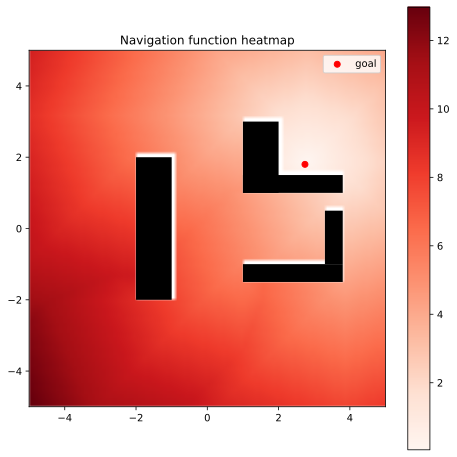

In [2]:
#Figure 9.a: Jupyter notebook must be run from the RoboticSystems/ directory for this code to work.
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from rsbook_code.utilities import graph,example_graphs
from rsbook_code.planning import grid_search
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import math

class NavigationFunction:
    """Stores results for a navigation function to the target xgoal"""
    def __init__(self,xgoal,xmin,xmax,resolution,
                 obstacle_test,obstacle_edge_test=None,
                 diagonals=True,verbose=0):
        self.xgoal = xgoal
        self.xmin = xmin
        self.xmax = xmax
        self.resolution = resolution
        #precompute costs-to-go across the grid
        _,self.distances,self.predecessors = grid_search.grid_search(xgoal,lambda x:False,xmin,xmax,resolution=resolution,
                              obstacle_test = obstacle_test,
                              obstacle_edge_test = obstacle_edge_test,
                              diagonals=diagonals,implicit=True,
                              verbose=verbose)
    def get_cost(self,x):    
        return grid_search.optimal_path_cost(x,self.distances,self.predecessors,self.xgoal,self.xmin,self.xmax,self.resolution)
        
    def get_path(self,x):
        prev = grid_search.optimal_path(x,self.distances,self.predecessors,self.xgoal,self.xmin,self.xmax,self.resolution)
        if prev is None: return None
        return prev[::-1]

#define search problem and obstacle boxes
xgoal = (2.74,1.8)
xmin = [-5,-5]
xmax = [5,5]
resolution = 0.1
obstacles = [([-2,-2],[-1,2]),
             ([1,1],[2,3]),
             ((1,1),(3.8,1.5)),
             ((1,-1.5),(3.8,-1)),
             ((3.3,-1),(3.8,0.5))
            ]
def in_obstacles(x):
    if x[0] < xmin[0] or x[1] < xmin[1] or x[0] > xmax[0] or x[1] > xmax[1]:
        return True
    global obstacles
    for a,b in obstacles:
        if a[0] <= x[0] <= b[0] and a[1] <= x[1] <= b[1]:
            return True
    return False

nav_fn = NavigationFunction(xgoal,xmin,xmax,resolution,in_obstacles,verbose=1)

#plot start, goal, and costs-to-go
def setup_dwa_plt():
    plt.figure(figsize=(8,8))
    plt.xlim(xmin[0],xmax[0])
    plt.ylim(xmin[1],xmax[1])
    #plot obstacles
    for a,b in obstacles:
        patch = patches.Rectangle(a,b[0]-a[0],b[1]-a[1],facecolor='k',zorder=1)
        plt.gca().add_patch(patch)
    plt.scatter([xgoal[0]],[xgoal[1]],c='r',zorder=2,label='goal')
    plt.gca().set_aspect('equal', 'box')

setup_dwa_plt()

#plot costs-to-go
distance_img = np.ones([int(math.floor((b-a)/resolution)) for (a,b) in zip(xmin,xmax)])*float('inf')
for (k,v) in nav_fn.distances.items():
    if isinstance(k,str): continue
    distance_img[k] = v
plt.imshow(distance_img.T,cmap=plt.cm.Reds, interpolation='none', extent=[xmin[1],xmax[1],xmax[0],xmin[0]])
plt.title("Navigation function heatmap")
plt.legend()
plt.colorbar()
plt.show()

Time to compute 100 paths: 0.0472412109375
Time to compute 100 optimal costs: 0.01568293571472168


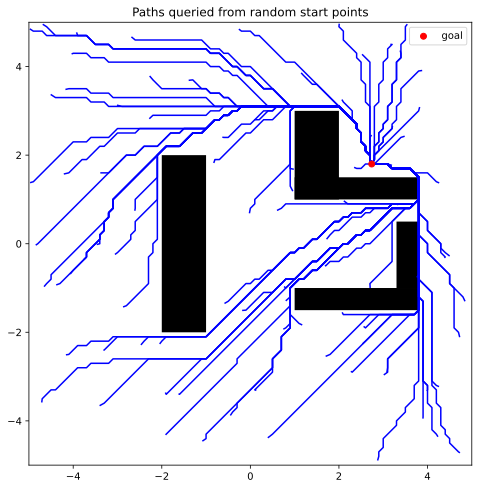

In [3]:
#Figure 9.b: Now can get optimal paths for many states quickly using the `nav_fn`
#`get_path` method.  Run this after the prior cell.
import random
import time

N = 100
starting_points = []
for i in range(N):
    x = [random.uniform(a,b) for (a,b) in zip(xmin,xmax)]
    starting_points.append(x)
t0 = time.time()
paths = []
for x in starting_points:
    path = nav_fn.get_path(x)
    paths.append(path)
t1 = time.time()
print("Time to compute",N,"paths:",t1-t0)
t0 = time.time()
for x in starting_points:
    c = nav_fn.get_cost(x)
t1 = time.time()
print("Time to compute",N,"optimal costs:",t1-t0)

setup_dwa_plt()

#plot paths
for p in paths:
    if p is not None:
        plt.plot([x[0] for x in p],[x[1] for x in p],c='b',zorder=1)
plt.legend()
plt.title("Paths queried from random start points")
plt.show()

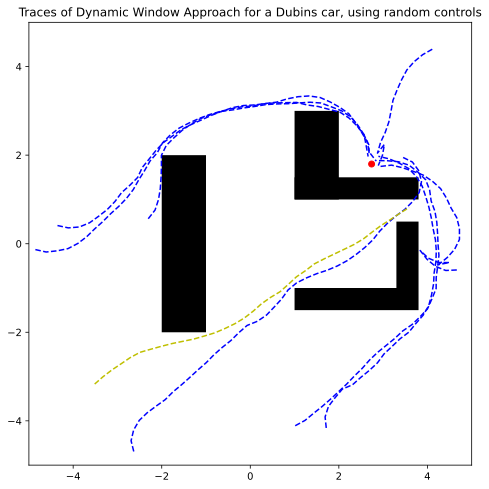

In [5]:
#Figure 9.c: This shows the dynamic window approach for a Dubins car vehicle
from rsbook_code.control.examples.dubins import DubinsCar,DubinsCarIntegrator
from rsbook_code.control.dynamics import simulate

dubins = DubinsCar(-2,2)
distance_resolution = 0.25
edge_check_divs = 5

#dynamic window approach 5 steps with randomly sampled paths
n_constant_samples = 20
n_random_samples = 20
horizon = 5

onestep_integrator = DubinsCarIntegrator(dubins,T=distance_resolution,dt=distance_resolution/edge_check_divs)

def sample_u():
    return [random.choice([-1,1]),random.uniform(*dubins.turnRateRange)]
    #return [random.choice([-1,1]),random.choice([dubins.turnRateRange[0],dubins.turnRateRange[0]*0.5,0,dubins.turnRateRange[1]*0.5,dubins.turnRateRange[1]])]

#weights in the scoring function
W_distance = 0.2
W_sign_changes = 0.5
W_heading_error = 0.1
W_collision = 10
    
def score_raw(xpath,upath,distance_weight=0.0):
    """Same as score, but assumes xpath is a collision-free path"""
    x = xpath[-1]
    if len(upath) == 0:
        return nav_fn.get_cost(x[:2])
    
    dir_sign = np.sign(upath[0][0])
    sign_changes = 0
    drive_dist = 0

    #accumulate the drive distance and the number of direction changes
    for u in upath:
        if dir_sign != np.sign(u[0]):
            sign_changes += 1
            dir_sign!= np.sign(u[0])
        drive_dist += abs(u[0])*distance_resolution

    #compute the heading error from the navigation function's gradient drection
    heading_error = 0
    path = nav_fn.get_path(x[:2])
    if path is not None and len(path) > 1:
        d = (path[1]-path[0])/np.linalg.norm(path[1]-path[0])
        dx = (math.cos(x[2]),math.sin(x[2]))
        heading_error = math.acos(np.dot(d,dx))
    return drive_dist*distance_weight*W_distance + sign_changes*W_sign_changes + nav_fn.get_cost(x[:2]) + heading_error*W_heading_error
    
def ufunc_traj(t,x,u_path):
    if t > len(u_path)*distance_resolution:
        return [0,0]
    return u_path[int(math.floor(t)*distance_resolution)]

def score(x,upath,distance_weight=0.0):
    """A pretty well-tuned scoring function for DWA, for this particular Dubins car model"""
    #simulate the path, perform collision checking along it. Stop when a collision is found.
    if len(upath)==0:
        xpath = [x]
    else:
        def open_loop_policy(t,x):
            i = int(math.floor(t/distance_resolution))
            return upath[min(i,len(upath)-1)]
        path = simulate(dubins,x,open_loop_policy,T=horizon*distance_resolution,dt=distance_resolution)
        xpath = path['x']
        upath = path['u']
        #stop path when it hits an obstacle
        for i,xi in enumerate(path['x']):
            if in_obstacles(xi):
                xpath = xpath[:max(1,i)]
                break
        
    #len(xpath)+1 is the number of feasible steps.  The latter term penalizes shorter feasible paths
    return score_raw(xpath,upath[0:len(xpath)-1],distance_weight) + W_collision*(len(upath)-len(xpath)+1)

def ufunc_random_dynamic_window(t,x):
    s0 = score(x,[])
    if s0 < 0.25:
        return (0,0)
    ubest = (0,0)
    distance_weight = 1.0 / (s0 + 0.01)
    sbest = s0 + horizon*distance_weight
    for i in range(n_constant_samples+n_random_samples):
        h = horizon
        #when getting close to the goal, add stopping as an option
        if s0 < 0.5:
            h = random.randint(1,horizon)
        if i < n_constant_samples:
            u_path = [sample_u()]*h
        else:
            u_path = [sample_u() for i in range(h)]
        s = score(x,u_path,distance_weight)
        if s < sbest:
            sbest = s
            ubest = u_path[0]
    if in_obstacles(onestep_integrator.nextState(x,ubest)):
        return (0,0)
    return ubest

setup_dwa_plt()


#can play around with this random seed to see different examples
random.seed(1234)
np.random.seed(1234)
xstarts = []
for n in range(10):
    xstart = (random.uniform(xmin[0],xmax[0]),random.uniform(xmin[1],xmax[1]),random.uniform(0,math.pi*2))
    if in_obstacles(xstart[0:2]):
        continue
    xstarts.append(xstart)

for xstart in xstarts:
    xpath = simulate(dubins,xstart,ufunc_random_dynamic_window,10,distance_resolution)['x']
    if any(in_obstacles(x[0:2]) for x in xpath):
        c = 'r'
    elif np.linalg.norm(np.array(xpath[-1][0:2])-xgoal) < 1:
        c = 'b'
    else:
        c = 'y'
    plt.plot([x[0] for x in xpath],[x[1] for x in xpath],c=c,linestyle='--')
    
plt.title("Traces of Dynamic Window Approach for a Dubins car, using random controls")
plt.show()

### Robust probabilistic scoring 

Looking closely at the Dubins car DWA example above, some of the curves appear to pass very close to obstacles.  This would be dangerous if the robot were not able to perfectly execute the generated paths, e.g. with wheel slippage or uneven ground.  In the below figure, the DWA planner was used exactly in the same way, but at each time step, a random disturbance to the movement direction was introduced.  This shows that with disturbances, the overly optimistic navigation function can cause replanning with DWA to collide into obstacles (red paths) or fail to reach the goal (yellow paths).

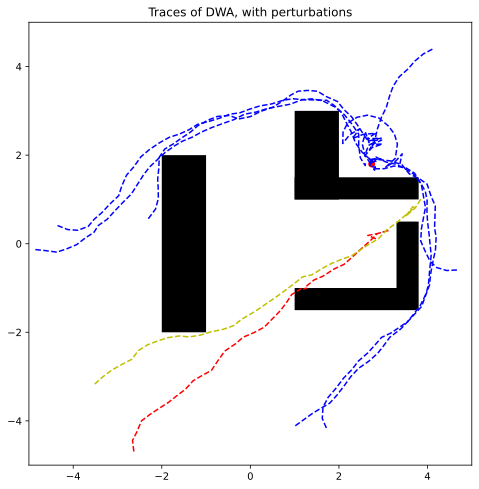

In [6]:
#Figure 10: Code simulating a Dubins car, with perturbations
spread = np.array([0.1,0.1,0.1])

class PerturbedDubinsCar(DubinsCar):
    def derivative(self,x,u):
        global spread
        dx = super().derivative(x,u)
        return dx + np.random.normal(scale=spread)

perturbed_dubins = PerturbedDubinsCar(*dubins.turnRateRange)

setup_dwa_plt()

#can play around with this random seed to see different perturbations
random.seed(1235)
np.random.seed(1235)
for xstart in xstarts:
    xpath = simulate(perturbed_dubins,xstart,ufunc_random_dynamic_window,T=10,dt=distance_resolution)['x']
    if any(in_obstacles(x[0:2]) for x in xpath):
        c = 'r'
    elif np.linalg.norm(np.array(xpath[-1][0:2])-xgoal) < 1:
        c = 'b'
    else:
        c = 'y'
    plt.plot([x[0] for x in xpath],[x[1] for x in xpath],c=c,linestyle='--')
    
plt.title("Traces of DWA, with perturbations")
plt.show()

The DWA approach does not predict the future effects of uncertainty that might push the robot off course.  A simple way of handling some of this uncertainty is to include the prediction uncertainty into the scoring function.

The problem is that when the planner generates a path, the robot can't predict exactly where it would end up after executing it, or whether it would hit an obstacle.  But having uncertainty doesn't mean "having no information": the robot is unlikely to hop across the environment, or to be spun 180° in a single step.  The actual path driven $y_{act}$ will be fairly close to the planned path $y_{plan}$, with some increasing spread as we go along.  A scoring function that quantifies the effect of this increasing spread is known as a *robust score*. 

We can quantify the spread by generating many hypothesized "futures" for the planned path, using *random sampling* to simulate the effect of uncertainty.  This type of approach is called a *Monte-Carlo method*.  Here we describe the basic function of the method without going too deep into detail about its probabilistic foundations. 

Using a random number generator, we generate (sample) $N$ perturbed trajectories that might be possible realizations of $y_{act}$.  The disturbance along the trajectory varies over the length of the trajectory, so it is assumed to be a function $\epsilon(s)$.  Specifically, let us assume that $y$ is comprised of $M$ time steps generated by a simulation function $h$, so that repeated application of $h(x,u)$ generates the planned path.  Specifically, let the planned trajectory $y_{plan}$ be a piecewise-linear interpolation of an array of states $x_{plan}[0],\ldots,x_{plan}[M]$ associated with controls $u_{plan}[0],\ldots,u_{plan}[M-1]$ such that $x_{plan}[i+1] = h(x_{plan}[i],u_{plan}[i])$. Then, we sample a perturbed trajectory by rolling out the simulation function plus a disturbance vector $\delta_x$ sampled at random.  Each element of the disturbance is generated in a localized spread around 0, e.g., a uniform distribution in the range $[-\sigma,\sigma]$ or a normal distribution with mean 0 and standard deviation $\sigma$.  Most e.g., Python's `random.uniform` or `random.gauss` functions.  Then, we generate the perturbed trajectory $y_{samp}$ as follows:

1. $x_{samp}[0] = x_{plan}[0]$.
2. For $k=0,...,M-1$, do:
   3. Sample a new value of $\delta_x$
   4. $x_{samp}[k+1] = h(x_{act}[k],u_{plan}[k]) + \delta_x$.

Observe that the overall error is an accumulation of multiple perturbations $\delta_x$.

One common robust scoring function is the expected score (average score), which is approximated by the average score over $N$ samples.  Letting $y_{samp}^1,\ldots,y_{samp}^N$ denote the $N$ samples around $y_{plan}$, this is defined as:

$$S_{avg} = \frac{1}{N} \sum_{k=1}^N S(y_{samp}^k).$$

Another possibility is to choose the maximum score, which (assuming the score should be minimized) encourages the robot to stay further away from "dangerous" areas that the robot might arrive at, but with low probability.

$$S_{max} = \max_{k=1}^N S(y_{samp}^k).$$

A similar effect is achieved using a *confidence bound*.  Defining $S_{std}$ as the standard deviation of the score, approximated using the samples as follows

$$S_{std} = \left( \frac{1}{N-1} \sum_{k=1}^N (S(y_{samp}^k)- S_{avg})^2 \right)^{1/2},$$

we define an upper confidence interval of the score as the average value penalized with the standard deviation, scaled by the parameter $\eta$:
$$S_{conf,\eta} = S_{avg} + \eta S_{std}.$$
The signficance of this formula is that $\eta$ increases, the likelihood that the actual score exceeds $S_{conf,\eta}$ decreases (rather sharply).  Assuming scores are normally distributed and $N$ is sufficiently large, we have
- $P(S(y_{act}) \geq S_{conf,\eta=0}) = 50\%$
- $P(S(y_{act}) \geq S_{conf,\eta=1}) \approx 15.9\%$
- $P(S(y_{act}) \geq S_{conf,\eta=2}) \approx 2.3\%$
- $P(S(y_{act}) \geq S_{conf,\eta=3}) \approx 0.1\%$.

The figure below shows the use of robust scoring in DWA.  Because colliding with obstacles is penalized, the method chooses paths that swing farther around the obstacles.  Note that compared to plain DWA, the computation time scales by a factor of $N$ (in this case, $N=20$).  To run this on-board a real robot at a reasonable rate, such as 10Hz, the code would need to be optimized or parallelized.  Fortunately, Monte Carlo sampling is trivially parallelizable.

Simulating from state 1 of 9
Simulating from state 2 of 9
Simulating from state 3 of 9
Simulating from state 4 of 9
Simulating from state 5 of 9
Simulating from state 6 of 9
Simulating from state 7 of 9
Simulating from state 8 of 9
Simulating from state 9 of 9


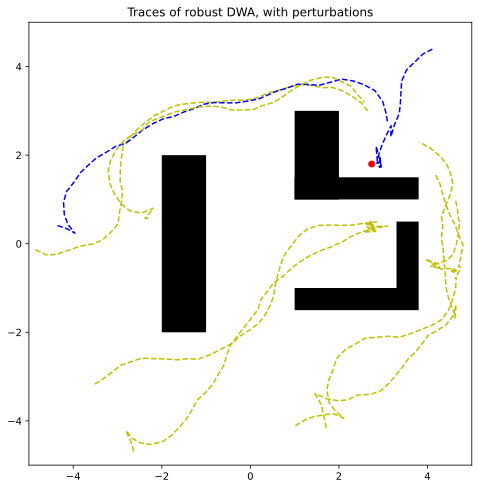

In [7]:
#Figure 11: Code demonstrating robust scoring in DWA

#how many samples of disturbances for each path
robust_sample_count = 20

#how much to disturb the state along each axis, at each time step
robust_spread = [0.1,0.1,0.1]

#the method for robust scoring.  Can be None, 'avg', 'max', and 'conf'
#robust_method = None
#robust_method = 'avg'
robust_method = 'conf'
#robust_method = 'max'

#if robust_method = 'conf'
conf_eta = 2.0

#collision probability weight
W_collision = 10


def robust_score(x,upath,distance_weight=0.0):
    global robust_sample_count,robust_method,conf_eta
    if robust_method == None:
        return score(x,upath,distance_weight)
    S0 = score(x,upath,distance_weight)
    Ssamples = []
    for i in range(robust_sample_count):
        #generate a trajectory xsamp
        xsamp = [x]
        state = x
        for u in upath:
            state = onestep_integrator.nextState(state,u) + np.random.normal(scale=robust_spread)
            if in_obstacles(state):
                break
            xsamp.append(state)
        #print("Penalty",(len(upath)-len(xsamp)+1))
        S = score_raw(xsamp,upath[:len(xsamp)-1],distance_weight) + W_collision*(len(upath)-len(xsamp)+1)
        Ssamples.append(S)
    if robust_method == 'avg':
        return np.average(Ssamples)
    elif robust_method == 'max':
        return np.max(Ssamples)
    elif robust_method == 'conf':
        return np.average(Ssamples) + conf_eta*np.std(Ssamples)
    else:
        raise ValueError("Invalid value of robust_method")

def ufunc_random_robust(t,x):
    s0 = score(x,[])
    if s0 < 0.25:
        return (0,0)
    ubest = (0,0)
    distance_weight = 1.0 / (s0 + 0.01)
    sbest = s0 + horizon*distance_weight
    for i in range(n_constant_samples+n_random_samples):
        h = horizon
        #when getting close to the goal, add stopping as an option
        if s0 < 0.5:
            h = random.randint(1,horizon)
        if i < n_constant_samples:
            u_path = [sample_u()]*h
        else:
            u_path = [sample_u() for i in range(h)]
        s = robust_score(x,u_path,distance_weight)
        if s < sbest:
            sbest = s
            ubest = u_path[0]
    if in_obstacles(onestep_integrator.nextState(x,ubest)):
        return (0,0)
    return ubest

setup_dwa_plt()

#can play around with this random seed to see different realizations of the perturbation
random.seed(1235)
np.random.seed(1235)
for k,xstart in enumerate(xstarts):
    print("Simulating from state",k+1,"of",len(xstarts))
    xpath = simulate(perturbed_dubins,xstart,ufunc_random_robust,T=10,dt=distance_resolution)['x']
    if any(in_obstacles(x[0:2]) for x in xpath):
        c = 'r'
    elif np.linalg.norm(np.array(xpath[-1][0:2])-xgoal) < 1:
        c = 'b'
    else:
        c = 'y'
    plt.plot([x[0] for x in xpath],[x[1] for x in xpath],c=c,linestyle='--')
    
plt.title("Traces of robust DWA, with perturbations")
plt.show()

### Markov Decision Processes (MDPs)

A second problem with the standard DWA approach is that the navigation function is constructed under the erroneous assumption that the robot can move precisely and instantaneously in any direction.  When the robot is at a grid point $(x,y)$, it has some orientation $\theta$ that can't be entirely predicted at the time of constructing the navigation function.  

A Markov Decision Process (MDP) is a principled method for representing decision-making problems under probabilistic movement uncertainty.  Using MDPs, we can calculate safer navigation functions that give suitable trade-offs between optimality and collision risk.  MDPs are also general-purpose, so they have been useful in modeling uncertainty in obstacle motion, wind gusts for UAVs, traffic delays, human behavior, as well as many other applications outside of robotics.

#### Simple example

In a discrete state space, an MDP can be thought of as a probabilistic extension of a discrete search problem, where after each action, the system doesn't just arrive at a single state, but could arrive with some probability at multiple states.  First, an MDP requires defining a state space $S$ and an *action space* $A$.

Let us start with a very simple example to illustrate the basic principles of MDPs (while also exploring some moral philosophy while we're at it!)  Let there be three states Alive, Heaven, and Hell. The robot starts at Alive, wants to arrive at Heaven, and does not want to arrive at Hell.  There are two actions, Mild and Wild, corresponding to how conservatively the robot chooses to live its life.  After choosing an action it will arrive at another state, or possibly the same state, according to the following rules.  If it chooses Mild, then there is a 90% chance of staying at Alive, and a 10% chance of arriving at Heaven.  If it chooses Wild, there is a 60% chance of arriving at Heaven, and 40% chance of arriving at Hell.  Once arriving at Heaven and Hell, the robot is done, but if it chooses Mild, there is some chance that it will stay Alive.  How, then, should the robot choose its actions? 

************
<a name="fig:SimpleMDP"></a>
    
<img alt="fig:SimpleMDP" src="figures/planning/simple_mdp.svg" width="70%">

<div class="figcaption"><b>Figure 12</b>. A very simple Markov Decision Process. States are indicated with ellipses, and decisions are indicated with boxes. Heaven and Hell are terminal states.  Rewards of each state are designated in blue.  The value of choosing Wild in the Alive state is the probability-weighted average of the two terminal rewards.  The value of choosing Mild is the probability-weighted average of the terminal reward of Heaven and the value of Alive.
</div>

************

To answer this question, there is a final missing ingredient in this formulation, which is the idea of a *reward function*.  The reward function $R$ allows us to assign a numerical score for a sequence of states and actions.  Let's suppose that arriving in Heaven has reward 100, Hell has reward -100, and staying Alive has reward of -1.  Then, the  expected (average) reward of choosing Wild while alive is 60-40% average of the rewards of arriving at Heaven and Hell, which is to say, $P(Heaven | Alive,Wild)\cdot R(Heaven) + P(Hell | Alive,Wild) \cdot R(Hell) = 0.6 \cdot 100 + 0.4 \cdot (-100) = 20$. Since after this, the robot is dead, we can't hope to get any more reward thereafter.  Let's call this expected value $Q(Alive,Wild)$.

Now, to assess the quality of the Mild action, it's a bit trickier, because there is a possibility for the state to stay the same (this is called a self-loop).  Over just the next step, the expected reward is $P(Heaven | Alive,Mild)\cdot R(Heaven) + P(Alive | Alive,Mild)\cdot R(Alive) = 0.1\cdot 100 + 0.9\cdot(-1) = 10-0.9 = 9.1$.  At the moment, this doesn't look any better than Wild.  But if the robot stays alive, it can choose additional actions and collect additional reward.  This sum of rewards is called a *return*.  Note, however, that the robot is able to change the action that it chooses from Mild to Wild, or stay the same.  The robot should consider the *best* possible action, that is, the one with the best expected return.  Specifically, the best possible expected return $V(Alive)$ at Alive is the one that maximises expected return amongst the two choices:

$$V(Alive) = \max (Q(Alive,Mild), Q(Alive,Wild)) $$

where we haven't set solved for $Q(Alive,Mild)$.  We can set up a recursive equation that depends on $V(Alive)$:
$$Q(Alive,Mild) = P(Heaven | Alive,Mild)\cdot R(Heaven) + P(Alive | Alive,Mild)\cdot (R(Alive) + V(Alive))  = 9.1 + 0.9 V(Alive).$$

We can then consider which of the two actions maximizes the $\max$ term in $V(Alive)$. If the best action were Wild, then $V(Alive) = Q(Alive,Wild) = 20$:

$$Q(Alive,Mild) = 9.1 + 0.9\cdot 20 = 27.1$$

This looks pretty promising!  On the other hand, if the best choice were to be Mild, then we have a recursive equation:
$$Q(Alive,Mild) = 9.1 + 0.9 Q(Alive,Mild).$$
Rearranging, we get $0.1 \cdot Q(Alive,Mild) = 9.1$, and dividing both sides by 0.1, we obtain $Q(Alive,Mild) = 91$. Ah, much better!  Since Mild is the better option, $V(Alive)$ is actually equal to $Q(Alive,Mild)$, and Mild is the optimal choice.

Now what would happen if robot received a reward of -10 for staying alive (say, it felt miserable cleaning up after humans)?  Then the calculus changes.  Repeating the above calculations, the value of 9.1 becomes only 1, and then $Q(Alive,Mild)$ becomes the maximum of 19 (choosing Wild thereafter) and 10 (choosing Mild thereafter).  This shows that Wild is the better choice, and $V(Alive)$ is equal to $Q(Alive,Wild)$ (which remains 20).  In general, the MDP decision model can obtain a very rich set of behaviors that balances uncertainty and action-dependent rewards. It is no wonder that MDPs are used throughout economics and behavioral sciences!  (Despite the seeming usefulness of MDPs in modeling metaphysical decisions about the afterlife in this example, they still haven't made much headway into the study of theology... how curious!)

#### Discrete MDP definition

Let's now consider a more complex problem to introduce the formal notation for MDPs.  Suppose we have a robot moving on a grid $G=(V,E)$, and every time it tries to move from one grid cell to an adjacent cell, it has some probability (say, 10%) of spinning its wheels and staying in place.  We can model this as the state space $S = V$, and an action space of up, down left, and right (denoted $A = \{ n, s, w, e \}$ like the compass directions).  When the robot is at a grid point $s=(i,j)$ and choses an action $a \in A$, there is some grid point $(i+\delta_{i,a},j+\delta_{j,a})$ offset by 1 on some axis that it would arrive at with 90% probability.  The robot would stay at the same grid point $(i,j)$ with 10% probability.  Letting $s^\prime$ denote the actual state that the robot arrives at, the MDP model states that the probability that $s^\prime = (i+\delta_{i,a},j+\delta_{j,a})$ is 0.9, and the probability that $s^\prime = s$ is 0.1.

************
<a name="fig:GridMDP"></a>
    
<img alt="fig:GridMDP" src="figures/planning/grid_mdp.svg" width="70%">

<div class="figcaption"><b>Figure 13</b>. A  Markov Decision Process encoding a robot moving on a grid with slippery wheels. In each direction, the robot has a 90% chance of successfully moving, and a 10% chance of staying in the same cell.
</div>

************

Formally, this is captured in a *transition function* $T(s,a,s^\prime)$ that gives the probability of arriving at $s^\prime$ given that action $a$ is chosen in state $s$.  In the above example, $T(s,a,s^\prime=s) = 0.1$, $T((i,j),a,s^\prime=(i+\delta_{i,a},j+\delta_{j,a})) = 0.9$, and $T(s,a,s^\prime) = 0$ for all other $s^\prime$.  In general, the transition function gives a conditional probability distribution over $s^\prime$, with $s$ and $a$ considered given.  In other words, $T(s,a,s^\prime) \equiv P(s^\prime \,|\, s,a)$ where the right hand side is the conditional probability.  According to the rules of probability, it must satisfy the given properties

- For all $s \in S$, $a \in A$, and $s^\prime \in S$, $T(s,a,s^\prime) \geq 0$
- For all $s \in S$ and $a \in A$, $\sum_{s^\prime \in S} T(s,a,s^\prime) = 1$

The final ingredient of an MDP is a reward function $R(s,a,s^\prime)$, that gives some numerical measure of reward that is given to the robot when it chooses action $a$ in state $s$, and a *terminal set* $G \in S$.  (Note that the idea of reward is basically the negative of cost, since we typically want to maximize rewards and reduce costs.)

By defining the reward function and terminal set, we are asking the robot to select actions to obtain future rewards that are as high as possible.  A *rollout* of a behavior is a sequence of states and actions: $s_0, a_0, s_1, a_1, s_2, \ldots$ either ending in a terminal state $S_T$, or continuing forever without hitting a terminal state. The *return* of a rollout is the sum of all rewards:

\begin{equation}
\sum_{t=0}^{T-1} R(s_t,a_t,s_{t+1}) \label{eq:Return}
\end{equation}

At state $s_t$ the robot cannot control exactly which value of $s_{t+1}$ it will arrive.  Instead, all it knows is that the probability distribution of $s_{t+1}$ is given by the transition distribution $T(s_t,a_t,s_{t+1})$.  So, it would like to maximize the expected return.

An MDP is completely specified with the tuple $(S,A,T,R,G)$.

#### Policies, value functions, and the Bellman equation

The form of a solution to an MDP is called a *policy*, which is a map $\pi(s) : S \rightarrow A$. It tells the robot what action to choose in *every* state, not just a path of states.

We define the *value of a policy* $\pi$ as a function $V_\pi(s)$ that gives the expected return of executing $\pi$ starting at $s$.  The expected return consists of the expected reward on the current action, plus the expected value for the subsequent states, calculated as follows:

\begin{equation}
V_\pi(s) = \sum_{s^\prime \in S} T(s,\pi(s),s^\prime) (R(s,\pi(s),s^\prime) + V_\pi(s^\prime)) \label{eq:ValueOfPolicy}
\end{equation}

An *optimal policy* is one in which the value of the policy is maximized over all possible policies.  The value of the optimal policy is also known as **the** value function $V^\star$ (often, just denoted $V$).  A celebrated result is that the value function is required to satisfy the **Bellman equation**, which chooses the optimal action via a $\max$ operation for any non-terminal nodes:

\begin{equation}
V(s) = \max_{a\in A} \sum_{s^\prime \in S} T(s,a,s^\prime) (R(s,a,s^\prime) + V(s^\prime)). \label{eq:BellmanEquation}
\end{equation}

And $V(s)=0$ for any terminal $s\in G$.

(To apply a reward upon reaching a terminal state, it must be added to $R(s,a,s^\prime)$ when $s^\prime \in G$. A common alternative formulation, which is less general but more convenient for some prolems, eliminates the $a$ and $s^\prime$ arguments from the reward function, and defines
- For $s \notin G$: $V(s) = R(s) + \max_{a\in A} \sum_{s^\prime \in S} T(s,a,s^\prime)V(s^\prime)$.
- For $s \in G$: $V(s) = R(s)$
.)

The optimal policy $\pi^\star(s)$ is simply given by replacing the $\max$ with an $\arg \max$:

\begin{equation}
\pi^\star(s) = \arg \max_{a\in A} \sum_{s^\prime \in S} T(s,a,s^\prime) (R(s,a,s^\prime) + V(s^\prime)). \label{eq:OptimalPolicy}
\end{equation}

Ties may be broken arbitrarily.

**Policy-value duality.** There is an interesting duality between policies and value functions.  As we have seen above, the value of a policy is given by $\eqref{eq:ValueOfPolicy}$. Moreover, for any numeric function $f$ over the states, we can define a *greedy policy* that optimizes the next action $a$ according to the best expected value of $f$ after applying $a$.
$$\pi_f(s) = \arg \max_{a\in A} \sum_{s^\prime \in S} T(s,a,s^\prime) (R(s,a,s^\prime) + f(s^\prime)). \label{eq:GreedyPolicy}$$
The optimal value function is the only value function for which the value of its greedy policy is itself; specifically, $V_{\pi^\star} = V$ where $\pi^\star = \pi_f$.  Likewise, an optimal policy is the only policy that is a greedy policy for its value function; i.e., $\pi_{f} = \pi^\star$ where $f = V_{\pi^\star}$.

**Sparse MDPs.**
Although in the previous discussion we have defined the maximum over all of $A$ and the expectation over all of $S$, in many MDPs only a few actions are applicable at any given state, and/or the transition probability is 0 for many states.  These MDPs are known as *sparse*.  For sparse MDPs, it is more computationally efficient to optimize only over the set of applicable states, and sum over the states for which the transition probability is nonzero.  To do so, we denote a subset of applicable actions $Appl(s) \subseteq A$ that are allowed to be applied in state $s$, and a subset of *successor states* $Succ(s,a) \subseteq S$ for which $s^\prime \in Succ(s,a)$ iff $T(s,a,s^\prime) \neq 0$.  Then, the maximizations in each of the above equations can be replaced with $\max_{a \in Appl(s)} \cdot$, and the summations can be replaced with $\sum_{s^\prime \in Succ(s,a)} \cdot$ without any change.

**Q-functions.**
For further study into MDPs, it is worth knowing that the value inside the maximum in $\eqref{eq:BellmanEquation}$ is known as the *Q-value*, which is defined over state-action pairs:

$$Q(s,a) = \sum_{s^\prime \in S} T(s,a,s^\prime) (R(s,a,s^\prime) + V(s^\prime))$$

With this definition, we see that $V(s) = \max_{a \in A} Q(s,a)$ and $\pi^\star(s) = \arg \max_{a \in A} Q(s,a)$.  The $Q$ formulation is frequently used in the reinforcement learning literature.

#### Conditions for solution existence

Solving the Bellman equation is not trivial, because it is a recursive equation with $V$ appearing on both sides, and with a nonlinear $\max$ term.  There is a possibility for the optimal policy to put the robot into an infinite loop, so that it obtains runaway (infinite) rewards.  

Roughly speaking, there are two types of MDP that prevent this type of degeneracy:
1. Regardless of the choice of actions, the robot will eventually reach a terminal state with probability 1.
2. Two conditions must hold: a) From any state, there is a nonzero probability of reaching a terminal state with some sequence of actions. b) All rewards are negative, except for those arriving at a terminal state.

In Type 1 MDPs, the probability that the robot doesn't terminate after $t$ steps decreases toward 0, so the rewards obtained after $t$ steps shrinks.  In Type 2 MDPs, there may be some policies that keep the robot into an infinite loop, but since all rewards are negative, infinite-looping policies will not be optimal.  (To make the argument precise, several technical conditions must be met, e.g., rewards are finite, and the number of states are finite.)

In other types of MDPs that don't satisfy these conditions, we can enforce the existence of a solution using slight modifications of the problem.

**Discounting**.  The MDP defined above is called an *undiscounted* MDP.  It is common to consider *discounted* MDPs where future rewards are reduced in value the later they are received.  This approach causes the robot to prefer shorter-term rewards over equivalent long-term rewards.  The most common *geometric discounting* method replaces the undiscounted return $\eqref{eq:Return}$ with the discounted return

\begin{equation}
\sum_{t=0}^{T-1} \gamma^t R(s_t,a_t,s_{t+1}) \label{eq:DiscountedReturn}
\end{equation}

where $\gamma$ is the *discount factor*, $\gamma \in (0,1]$.  The case $\gamma=1$ is equivalent to the undiscounted $\eqref{eq:Return}$, and for smaller $\gamma$ the robot will ignore larger rewards that take a long time to reach.  This is an approximate model of economic behavior, since the inflation-adjusted value of a dollar is less 10 years from now than it is now.

One reason why geometric discounting is so popular is that it leads to extremely mathematically-convenient expressions for the discounted value of a policy and the discounted Bellman equation. All we need to do is insert a factor of $\gamma$ into $\eqref{eq:ValueOfPolicy}$ and $\eqref{eq:BellmanEquation}$ as follows:

\begin{equation}
V_\pi(s) = \sum_{s^\prime \in S} T(s,\pi(s),s^\prime) (R(s,\pi(s),s^\prime) + \gamma V_\pi(s^\prime)) \label{eq:DiscountedValueOfPolicy}
\end{equation}

\begin{equation}
V(s) = \max_{a\in A} \sum_{s^\prime \in S} T(s,a,s^\prime) (R(s,a,s^\prime) + \gamma V(s^\prime)). \label{eq:DiscountedBellmanEquation}
\end{equation}

Interestingly, it also leads to provable existence of an optimal solution for MDP.

To show why this is the case, let us order all of the states in $S$ as integers, so that we can represent the value function $V_\pi$ as a vector $\mathbf{v}$ of length $|S|$.  Given $\pi$, let us also define the $|S| \times |S|$ transition matrix $T_\pi$ where the entry corresponding to column $s$ and row $s^\prime$ gives the transition probability $T(s,\pi(s),s^\prime)$.  For all terminal states $s$, let the row and column of $T_\pi$ corresponding to $s$ be all zeroes except the $(s,s)$ entry, which takes the value of 1.  We will also define the length-$|S|$ reward vector $\mathbf{r}$ where the entry corresponding to $s$ is $\sum_{s^\prime \in S} T(s,\pi(s),s^\prime) R(s,\pi(s),s^\prime)$.

With this definition, it can be seen that the expression $\eqref{eq:DiscountedValueOfPolicy}$ of the value function can be written as
\begin{equation}
\mathbf{v} = \mathbf{r} + \gamma T_\pi \mathbf{v}.
\end{equation}

By rearranging, we get the expression

\begin{equation}
(I - \gamma T_\pi) \mathbf{v} = \mathbf{r}
\end{equation}

and if $I - \gamma T_\pi$ is invertible, we can solve via matrix inversion:

\begin{equation}
\mathbf{v} = (I - \gamma T_\pi)^{-1} \mathbf{r}.
\label{eq:MDPInversion}
\end{equation}

In the undiscounted ($\gamma=1$) case, $T_\pi$ may contain some entries with value 1, e.g., terminal states have 1 on the diagonal.  So, showing that $(I - T_\pi)\mathbf{v} = \mathbf{r}$ has a solution is rather non-trivial and requires assumptions about the structure of $T_\pi$.  However, in the discounted ($\gamma < 1$) case, every entry of $\gamma T_\pi$ is in the range $[0,\gamma]$ (and also $[0,1)$).  Moreover, each row of $T_\pi$ sums to 1, so the sum of the values of row $s$ minus the diagonal is just $1-T_\pi[s,s]$.  Hence, considering row $s$ of $I - \gamma T_\pi$, the diagonal entry is $1 - \gamma T_\pi[s,s]$, and the off-diagonal entries sum to $-\gamma (1-T_\pi[s,s])$.  Since $1 - \gamma T_\pi[s,s] > \gamma (1-T_\pi[s,s])$, the matrix is strictly diagonally dominant, which implies that it has an inverse.

**Finite-horizon solving**. This approach simply forces the robot to terminate automatically after $N$ steps, which turns the infinite-horizon MDP problem into a finite-horizon one.  The typical approach for formulating a finite-horizon so by *time-stamping* the state.  Essentially, a time-stamped problem creates an augmented state space $\tilde{S}$ where each element is a (state,time) pair $(s,t)$ with $s\in S$.  The transition function always moves one time step ahead, so that $\tilde{T}((s,t),a,(s^\prime,t+1)) = T(s,a,s^\prime)$ and $\tilde{T}((s,t),a,(s^\prime,t^\prime)) = 0$ for any $t^\prime \neq t+1$.  The goal set is also augmented: $\tilde{G} = \{ (s,t) \,|\, s\in G \text{ or }t = N \}$.  The augmented MDP $(\tilde{S},A,\tilde{T},R,\tilde{G})$ satisfies the Type 1 condition.


#### Value iteration 
One of the most common algorithms to solve an MDP is *value iteration* (VI).  It proceeds as follows:

*******************
<a name="alg:ValueIteration"></a>
**Algorithm Value Iteration**
1. Guess an initial value function $V^0 : S \rightarrow \mathbb{R}$.  An uninformed guess assumes all 0's.
2. For some number of iterations $t=1,2,3,\ldots,N$, repeat:
3. &nbsp;&nbsp;&nbsp; Compute an updated value function $V^{t}$ from the left hand side of the Bellman equation $\eqref{eq:DiscountedBellmanEquation}$, replacing the value function on the right hand side with $V^{t+1}$ (Bellman update)
4. Output $V^N$.
********************

More precisely, the Bellman update step 3 assigns the value of 0 to all terminal nodes, and performs the following assignment for all non-terminal nodes:

\begin{equation}
V^t(s) \gets \max_{a\in A} \sum_{s^\prime \in S} T(s,a,s^\prime) (R(s,a,s^\prime) + \gamma V^{t-1}(s^\prime)). \label{eq:BellmanUpdate}
\end{equation}

Value iteration has some interesting properties:

* Discounted value iteration ($\gamma<1$) is proven to converge to the optimal value function as $N$ increases.  Moreover, undiscounted value iteration ($\gamma=1$) is proven to converge if the optimal value function is finite.  This holds regardless of the initial value function guess.  
* The convergence rate is improved when $V^0$ is a good approximation of $V^\star$.
* Another termination criterion, rather than running for a fixed number of steps, terminates when no entry of $V^t$ and $V^{t+1}$ exceeds a threshold $\epsilon$.  If the maximum reward $R_{max}$ is known and $\gamma < 1$, choosing $N > \log \epsilon / \log \gamma $ suffices.
* The computational complexity of value iteration is $O(|S|^2 |A| N)$.  This can be reduced to $O(|S| |A| N)$ if it is known that after each action, the probability of transition is nonzero for $O(1)$ states.  It can also be completed in $O(|S|)$ space complexity, by swapping the storage of $V^t$ and $V^{t-1}$ at each iteration.
* After $N$ steps of value iteration, the value function $V^N$ is the optimal horizon-$N$ finite-horizon MDP.

In the example below, a 10x10 grid has a goal in the upper-right corner, and an obstacle in the 6th column.  Diagonal movements are allowed.  When choosing a direction to move, there is a 25% chance of moving in an arbitrary direction.

************
<a name="fig:GridMDP2"></a>
    
<img alt="fig:GridMDP2" src="figures/planning/grid_mdp2.svg" width="40%">

<div class="figcaption"><b>Figure 14.a</b>. The motion model for the value iteration and policy iteration examples below.
</div>

************

The goal gives a reward of 1 and hitting the obstacle gives a reward of -10.  Each step also induces a cost of 0.01 times the length of the move.  The plot shows the value function as a heatmap, and the greedy policy associated with the value function is drawn with arrows.

In the initial steps of value iteration, the portion of the map near the goal has a good sense to move away from the obstacle and up toward the goal. However, there is a large portion of the map in which the solver does not "know" a policy leading to the goal, since the information about that reward has yet not propagated through values at the intermediate states.

After a couple dozen further iterations, the value function converges within a tolerance of 10<sup>-3</sup>, and all states have an adequate sense of how to best reach the goal. When the robot is near the obstacle, the policy tells it to move away from the obstacle, but when it is farther away, it seeks toward the goal.

Value iteration did not converge after 3 iterations
Value iteration did not converge after 7 iterations
Value iteration converged after 28 iterations
Solution time 0.12044072151184082


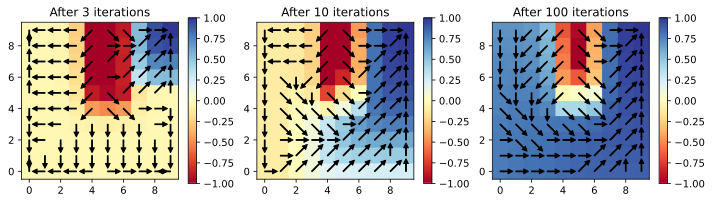

In [8]:
# Figure 14.b: Value iteration example. Code must be run from this folder
from __future__ import print_function,division

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%autoreload 2

import matplotlib.pyplot as plt
from rsbook_code.utilities import mdp
from rsbook_code.utilities import example_mdps
from rsbook_code.utilities import example_graphs

#make a grid
M,N = 10,10
G = example_graphs.grid_graph(M,N,diagonals=True)
goal_state = (M-1,N-1)
obstacles = set([(i,N//2) for i in range(M//2,M)])
#rewards are slightly negative if not at the goal, otherwise +1 is received
def reward(s,a=None,sn=None):
    if s == goal_state:
        return 1
    if sn in obstacles:
        return -10
    return -0.01*np.linalg.norm(np.array(s)-np.array(sn))
#25% chance of going in the desired direction
problem = example_mdps.GraphMDP(G,terminal=[goal_state],pError=0.25)
problem.num_reward_args = lambda:3
problem.reward = reward
t0 = time.time()
solver = mdp.DiscreteMDPSolver(problem)
t1 = time.time()
#print("Structure computation time",t1-t0)

"""
#try a rollout
def right_up_policy(s):
    return (s[0]+1,s[1]) if s[0]+1 < M else (s[0],s[1]+1)
rollout = solver.sample_rollout((0,0),right_up_policy,max_steps=100)
if rollout[-1] == goal_state:
    print("Rollout arrived at goal")
#print("Rollout states",solver.rollout_states(rollout))
print("Rollout return",solver.rollout_return(rollout))
"""
#do value iteration
t0 = time.time()
values = solver.value_iteration(N=3,verbose=1)
values3 = values
values = solver.value_iteration(initial_values=values,N=7,verbose=1)
values10 = values
#print("Values after 10 iterations",values)
values = solver.value_iteration(initial_values=values,N=90,verbose=1)
t1 = time.time()
#print("Values after 100 iterations",values)
print("Solution time",t1-t0)


fig,ax = plt.subplots(1,3,figsize=(12,3))
cbar = ax[0].imshow(values3.reshape((M,N)),cmap='RdYlBu',vmin=-1,vmax=1,origin='lower')
ax[0].set_title("After 3 iterations")
policy3 = solver.greedy_policy(values3)
for s,a in zip(solver.states,policy3):
    if a is not None:
        n = (0.5*(a[0]-s[0]),0.5*(a[1]-s[1]))
        ax[0].arrow(s[1],s[0],n[1],n[0],width=0.05,head_width=0.3,head_length=0.3,color='k')
fig.colorbar(cbar,ax=ax[0])

cbar = ax[1].imshow(values10.reshape((M,N)),cmap='RdYlBu',vmin=-1,vmax=1,origin='lower')
ax[1].set_title("After 10 iterations")
policy10 = solver.greedy_policy(values10)
for s,a in zip(solver.states,policy10):
    if a is not None:
        n = (0.5*(a[0]-s[0]),0.5*(a[1]-s[1]))
        ax[1].arrow(s[1],s[0],n[1],n[0],width=0.05,head_width=0.3,head_length=0.3,color='k')
fig.colorbar(cbar,ax=ax[1])

cbar2 = ax[2].imshow(values.reshape((M,N)),cmap='RdYlBu',vmin=-1,vmax=1,origin='lower')
ax[2].set_title("After 100 iterations")
policy = solver.greedy_policy(values)
for s,a in zip(solver.states,policy):
    if a is not None:
        n = (0.5*(a[0]-s[0]),0.5*(a[1]-s[1]))
        ax[2].arrow(s[1],s[0],n[1],n[0],width=0.05,head_width=0.3,head_length=0.3,color='k')
fig.colorbar(cbar2,ax=ax[2])

plt.show()

#### Policy iteration

The second most popular MDP solution technique is *policy iteration* (PI).  Its motivation is that the value function estimates computed by VI will still change, even when the optimal actions determined by $\eqref{eq:OptimalPolicy}$ have already converged.  So, it focuses on iterating over better policies $\pi$, and using $\eqref{eq:MDPInversion}$ to determine the value of the policy. Its pseudocode is as follows:

****************
<a name="alg:PolicyIteration"></a>
**Algorithm Policy Iteration**
1. Guess a policy $\pi$, and set $changed$ to true.
2. While $changed$ = true, repeat:
3. &nbsp;&nbsp;&nbsp; Calculate the value of policy $\pi$: $ \mathbf{v} = (I - \gamma T_\pi)^{-1} \mathbf{r}. $
4. &nbsp;&nbsp;&nbsp; $changed \gets$ false.
5. &nbsp;&nbsp;&nbsp; For all states $s\in S$, update the best action:
6. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; Calculate $v[a] \gets \sum_{s^\prime} T(s,a,s^\prime) (R(s,a,s^\prime) + V_\pi(s^\prime))$ for all $a$.
7. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; If $v[\pi(s)] \neq \max_{a\in A} v[a]$
8. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; Set $\pi(s) \gets \arg \max_{a\in A} v[a]$
9. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; $changed \gets$ true
10. Return $\pi$
***************************

Line 3 uses matrix inversion $\eqref{eq:MDPInversion}$ to calculate the true value of the current policy. If $T_\pi$ is a sparse matrix (which is a typical case), then sparse matrix techniques can be used to solve this equation quickly, possibly as low as $O(|S|)$ time.  Lines 6--9 update the best action for state $s$ and mark whether the policy has changed.

PI can be proven to converge to the optimal policy in a finite number of iterations.  The gist of the proof is to first observe that the only case in which the policy remains unchanged during an iteration is if the policy is optimal. Second, we show that PI will never proceed in an infinite loop of suboptimal policies.  There are a finite number of possible policies ($|S|^{|A|}$) and there is no way that a policy will ever be obtained at a later iteration.  Hence, it will encounter an optimal policy in no more than $|S|^{|A|}$ iterations.

The example below shows policy iteration applied to the same problem.  Note that in very few iterations, the policy converges to optimal.  However, each iteration is somewhat more expensive than value iteration, and the overall running time is approximately the same.

Policy iteration 0 , value function average -2680.0175487272736
Policy iteration 1 , value function average -2.492154558791279
Policy iteration 2 , value function average 0.1796111854628869
Policy iteration 3 , value function average 0.5991040381480266
Policy iteration 4 , value function average 0.6002344629692707
Policy iteration 5 , value function average 0.6004149394748883
Policy iteration 6 , value function average 0.6004931436814579
Policy iteration 7 , value function average 0.6005137297430703
Policy iteration converged in 8 iterations
Policy iteration time 0.20199155807495117


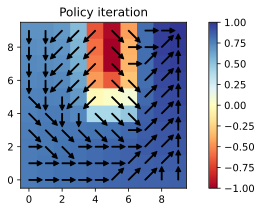

In [9]:
# Figure 15: Policy iteration example. Must be run after above value iteration example.
"""
#test of single policy solve timing
t0 = time.time()
values = solver.value(right_up_policy)
t1 = time.time()
print("Values of right-up-policy",values)
print("Computed in time",t1-t0)
"""
t0 = time.time()
#policy = solver.policy_iteration(right_up_policy,N=10)
policy = solver.policy_iteration(N=100,verbose=1)
t1 = time.time()
#print("Values after policy iteration",solver.value(policy))
print("Policy iteration time",t1-t0)

fig,ax = plt.subplots(1,1,figsize=(8,3))
cbar = ax.imshow(values.reshape((M,N)),cmap='RdYlBu',vmin=-1,vmax=1,origin='lower')
ax.set_title("Policy iteration")
for s,a in zip(solver.states,policy):
    if a is not None and s != goal_state:
        n = (0.5*(a[0]-s[0]),0.5*(a[1]-s[1]))
        ax.arrow(s[1],s[0],n[1],n[0],width=0.05,head_width=0.3,head_length=0.3,color='k')
fig.colorbar(cbar,ax=ax)
plt.show()

#### Application to robust navigation functions

We can use MDPs to compute a robust navigation function that takes into account the robot's motion uncertainty.  Again, an error rate of 25% is added to the transition function.  Since the grid is 100x100, there are 10,000 states in the MDP and 8 actions per state.  As a result, value iteration is much slower than in the above examples, and policy iteration takes 10s of seconds to complete.  Nevertheless, observe in the figure below that the navigation function now has rings of higher cost around the obstacles, which will encourage the robot to move around obstacles with more clearance.  In particular, the navigation function now tells the robot to go around the narrow passage rather than through it to avoid the risk of colliding.

The second plot shows how standard DWA, using the robust navigation function in the scoring function, is also able to reject disturbances by staying closer to the center of hallways.  This comes at some expense of taking somewhat longer paths.  Note that DWA remains fast because it does not use any extra sampling to estimate scores like the probabilistic scoring function did; all of the reasoning about uncertainty has been pushed to the precomputation phase.

Policy iteration solve time 43.68723464012146


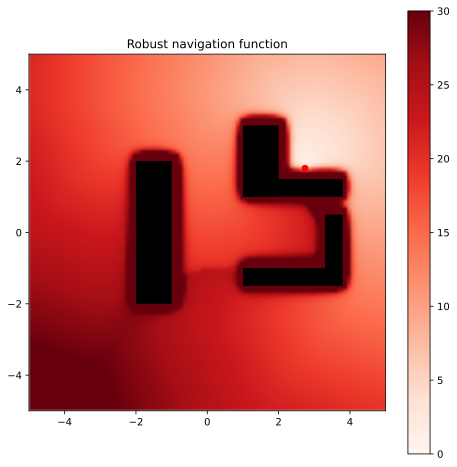

In [10]:
# Figure 16.a: Code for the robust navigation function approach

from rsbook_code.utilities import mdp
from rsbook_code.utilities import example_mdps
from rsbook_code.utilities import example_graphs
#define search problem and obstacle boxes
xgoal = (2.74,1.8)
xmin = [-5,-5]
xmax = [5,5]
resolution = 0.1
obstacles = [([-2,-2],[-1,2]),
             ([1,1],[2,3]),
             ((1,1),(3.8,1.5)),
             ((1,-1.5),(3.8,-1)),
             ((3.3,-1),(3.8,0.5))
            ]
def in_obstacles(x):
    global obstacles
    for a,b in obstacles:
        if a[0] <= x[0] <= b[0] and a[1] <= x[1] <= b[1]:
            return True
    return False

xmax = np.array(xmax)
xmin = np.array(xmin)
invresolution  = 1.0/resolution
dims = [int(math.floor(v)) for v in np.multiply(xmax-xmin,invresolution)]
G = example_graphs.grid_graph(dims[0],dims[1],diagonals=True)
goal_node = tuple(((np.array(xgoal)-xmin)*invresolution).astype(int))
def reward_fn(s,a,sn=None):
    if s == goal_node:
        return 0.0
    if in_obstacles(xmin + np.array(s)*resolution):
        return -100.0
    return -np.linalg.norm(np.array(s)-np.array(a))*resolution

t0 = time.time()
problem = example_mdps.GraphMDP(G,terminal=[goal_node],pError=0.5)
problem.num_reward_args = lambda:2
problem.reward = reward_fn

solver = mdp.DiscreteMDPSolver(problem)
policy = solver.policy_iteration(N=10)
value = solver.value(policy)
t1 = time.time()
print("Policy iteration solve time",t1-t0)

setup_dwa_plt()
plt.imshow(-value.reshape((dims[0],dims[1])).T,cmap=plt.cm.Reds, interpolation='none', vmin=0,vmax=30, extent=[xmin[1],xmax[1],xmax[0],xmin[0]])
plt.title("Robust navigation function")
plt.colorbar()
plt.show()

C:\Users\hause\AppData\Local\Temp\ipykernel_40344\857621357.py:47: RuntimeWarning: invalid value encountered in divide
  d = (path[1]-path[0])/np.linalg.norm(path[1]-path[0])


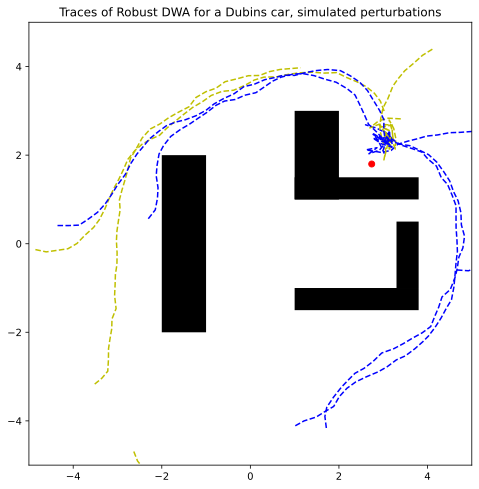

In [11]:
# Figure 16.b: This cell runs DWA on the robust navigation function, with perturbations. 

nav_fn_grid = -value.reshape((dims[0],dims[1]))
class ValueFunctionNavFn:
    def __init__(self,nav_fn_grid):
        self.nav_fn_grid = nav_fn_grid
    def get_cost(self,x):
        cell = ((x-xmin)*invresolution).astype(int)
        cell = np.maximum(cell,0)
        cell = np.minimum(cell,np.array(dims)-1)
        res = nav_fn_grid[cell[0],cell[1]]
        return res*0.5
    def get_path(self,x):
        c0 = self.get_cost(x)
        h = resolution
        c1 = self.get_cost(x+[h,0])
        c2 = self.get_cost(x+[0,h])
        grad = np.array([(c1-c0)/h,(c2-c0)/h])
        return [x,x-grad*resolution]
        
#replacement for prior nav_fn
nav_fn = ValueFunctionNavFn(nav_fn_grid)
    
#weights in the scoring function
W_distance = 0.2
W_sign_changes = 0.5
W_collision = 10


setup_dwa_plt()

random.seed(1234)
np.random.seed(1234)
for xstart in xstarts:
    xpath = simulate(perturbed_dubins,xstart,ufunc_random_dynamic_window,T=10,dt=distance_resolution)['x']
    if any(in_obstacles(x[0:2]) for x in xpath):
        c = 'r'
    elif np.linalg.norm(np.array(xpath[-1][0:2])-xgoal) < 1:
        c = 'b'
    else:
        c = 'y'
    plt.plot([x[0] for x in xpath],[x[1] for x in xpath],c=c,linestyle='--')
    
plt.title("Traces of Robust DWA for a Dubins car, simulated perturbations")
plt.show()

Planning under partial and noisy information
-----------------------------

Planning algorithms are usually designed under the assumption that the information about environmental
obstacles is complete and correct. However, this is rarely the case, which can cause problems during execution. If some obstacles are unobserved or imperfectly
sensed, then the robot may happily start to execute its solution path
(which is feasible according to the robot's model), but in reality the
robot might end up colliding!

Although it is possible to devise planners that reason explicitly with these types
of unknowns to produce *sensor-based plans* (information space planning),
these approaches are relatively complex and typically beyond the scope of an
introductory robotics course. Instead, here we will focus on practical ways of handling
these issues either by modifying the costs and constraints of existing
planners, or by modifying how they are invoked during the robot's sense-plan-act loop.


### Optimistic replanning under missing data

To handle missing data, one straightforward and effective approach is to
ensure that the robot senses around itself as it moves, and then replans
when the previous plan becomes invalidated by a newly-sensed obstacle.
With an *optimistic replanning* strategy, the robot assumes that any
areas that have not been observed are obstacle-free. Then, its first
path will navigate around observed obstacles and then proceed straight to
the goal. As it starts to execute the path, it will update its map
representation using sensor data, and then a *plan execution* module
will repeatedly verify whether the current plan is still valid. If an
obstacle is observed in the previously unseen location, then the robot
will replan and find an alternate route.

************
<a name="fig:OptimisticReplanning"></a>
    
TODO

<div class="figcaption"><b>Figure 17</b>. Illustrating the optimistic replanning strategy. The robot generates plans using known obstacles, and updates the map as it drives. When the path is invalidated by a new obstacle, the robot replans with the latest map.</div>

************

Another variant of this
approach would simply replan at regular intervals. This would work best
with a fast planner, so that new obstacles can be reacted to quickly, as
well as an optimizing planner, to ensure that the paths do not vary too
wildly as more sensor data is incorporated.

In either case, we need to develop the robot so that it is actually able to
anticipate obstacles when it updates its map.  If our robot's cameras or
laser sensors have a limited field of view, then we would need to be careful to
guide the robot along its path so that it looks in the direction of movement.
If you were to walk through a building backwards, you would be very likely to bump into
something or to trip!  More formally, you would want to orient the robot as it executes
the path so that its sensor coverage area always covers the swept volume of the robot along the path.
(How would you do this? It's left as an exercise.) 
It would also suffice to use 360° sensors (like spinning laser sensors) or
to add multiple sensors to provide omnidirectional coverage.

Optimistic replanning is also an effective strategy to handle slowly moving,
non-adversarial obstacles.

### Sensor noise and probabilistic collision detection

To handle noisy observations, _collision margins_ are a simple and often effective approach.
The idea is simply is to fatten the obstacles (or the robot geometry)
used by the planner by some margin of error $\epsilon$. Hence, path
produced by the planner will never pass within $\epsilon$ distance of
the sensed obstacles. If the threshold $\epsilon$ is chosen
appropriately to encapsulate all of the errors of the sensor at hand,
the robot will not collide while executing. However, if the threshold is
made too large, the planner may fail to find a path through a narrow
passage.

There are a few solutions in the latter case: either 
1. Use sensors with higher accuracy.
2. Use *probabilistic costs* that penalize paths that are likely to collide, rather than 
   forbidding them entirely.
3. Use *active sensing* techniques that predict and reason about how future sensor measurements may change the robot's knowledge about the world.

Approach 1 is a hardware-focused approach, and at some point, sensor performance is going to be limited by physics, price, weight, or power consumption.  Approach 2 and 3 are software focused, and although approach 3 is hypothetically a more principled approach to the problem, we will not be able to cover these approaches within the scope of this book (we will discuss why in [Section 4.4](#Information-space-and-many-worlds-interpretation).  So, let us say a few words about Approach 2.

The idea of probabilistic costs is simply to assign a cost that is high when paths pass close to obstacles and low when they do not.  Specifically, a sensible choice is to assign a cost based on the negative *log-likelihood* of segment feasibility:
$$c(a,b) = -\log P\left(\overline{ab} \subset \mathcal{F}\right).$$
A nice property of this cost is that a path that minimizes this cost also maximizes the probability that the path is feasible, assuming each segment is independent. More formally,
$$\arg \min_y \sum_{(a,b)\in y} -\log P\left(\overline{ab} \subset \mathcal{F}\right) = \arg \max_y \sum_{(a,b)\in y} \log P\left(\overline{ab} \subset \mathcal{F}\right) = \arg \max_y \prod_{(a,b)\in y} P\left(\overline{ab} \subset \mathcal{F}\right) \approx P(y\subset \mathcal{F}).$$
Of course, the collision status of each edge is not independent, but this is a fair approximation because in the cases that we typically care about, the robot doesn't take on too much risk of collision, and the approximation is better when there are fewer chances to collide.

To assess the log collision probability, we can use a probabilistic model of the error of measuring each obstacle. If $O$ is the true workspace obstacle, and our measurement provides us with an estimate $\hat{O}$, we could model the probability $P(O\subseteq \hat{O}_\delta)$ that $O$ lies within a version of $\hat{O}$ dilated by distance $\delta$.  For example, if the sensor noise is roughly a zero-mean Gaussian distribution with standard deviation $\sigma$, we could model $P(O\subseteq \hat{O}_\delta) = \Phi(\delta/\sigma)$ where $\Phi$ is the c.d.f. of the unit Gaussian distribution.  As the dilation $\delta$ grows large, this probability approaches 1, and as the dilation shrinks, the probability approaches 0.  (Note that this is an extremely simplified model of how sensor noise affects the shape of obstacles, but for most robotics applications is produces reasonable results.)

Then, the probability that $\overline{ab} \in \mathcal{F}$ is related to the workspace clearance of the robot as it traverses $\overline{ab}$. If the clearance from $\hat{O}$ is $\epsilon$, then the probability that $\overline{ab} \in \mathcal{F}$ is simply modeled as $\Phi(\delta/\sigma)$.  The edge cost would then be set to $-\log \Phi(\delta/\sigma)$.  (Note that this can be approximated extremely well by the cheaper function $0.115\max\left(0,-\frac{\delta}{\sigma}+2\right)^{2.5}$.)

The problem with this approach is that it may take extremely long paths, so instead the cost is usually set to some weighted sum of movement cost and log probability of feasibility, e.g. $c(a,b) = w\|a-b\| - \log P(\overline{ab}\subset \mathcal{F})$. A minimum-cost path will therefore trade off between efficiency of execution and likelihood of collision.  

### Active sensing

*Active sensing* problems require the robot to choose its actions deliberately to gather information
in order to complete its task.  For example, for inspection problems, or building a map of an unknown
environment, the objective itself is to gather data. To use a utensil in an unknown kitchen, the robot
must first find the utensil by opening drawers and cabinets.  In these cases, an effective strategy
for planning is to 1) quantify the *information gain* from a hypothetical state in a manner that
can be used in the planner's scoring function, and 2) allow the planner to choose between multiple
goals, picking the one that best balances the value of information, overall task achievement, and
movement cost.

#### Pure information gathering: next best view planning

Let us first consider the problem of map-building, which is a pure information gathering problem. Let
us assume a 2D problem with a mobile robot with a configuration space $\mathcal{C}$ in SE(3), with configuration $q=(x,y,\theta)$.  Let $M$ be a partial map, given by a 2D probabilistic occupancy grid.  The map defines
$M(x,y) = 1$ if the workspace
point $x,y$ is *occupied* by an obstacle, $M(x,y) = 0$ if the point is known to be *free*, and $M(x,y) = 0.5$
if its contents are *unknown*.  As the robot moves, the map is updated using some mapping algorithm.

Suppose the robot has a sweeping laser sensor mounted on its center, pointed in its forward direction, and it has
an angular range of $\pm \theta_{max}$. Each scan provides $N$ readings within the angular range, and the maximum
distance is $d_{max}$.  Using this sensor model, we can predict how much of the map's unexplored boundary can be sensed from a new configuration $q$. The problem of finding the best viewpoint to aid exploration is also known as the **next best view** planning problem. 

At $q$, each laser scan ray emanates from $(x,y)$ with heading $\theta + \theta_{laser,i}$, with $\theta_{laser,i} = -\theta_{max} + 2 (i-1) / (N-1) \theta{max}$, for $i=1,\ldots,N$.  At points $p_1,p_2,...,$ along this ray, we walk along the occupancy grid, up to distance $d_{max}$, and evaluate the contents of the map $M(p_j)$.  If we meet a point that is occupied or unknown ($M(p_j)=0.5$ or 1), we stop.  If we stop only by hitting the robot's sensor range $d_{max}$, or $M(p_j)$ is occupied, then the ray is not expected to provide any information at $q$.  If $M(p_j)$ is unknown, then we can expect for this ray to provide the robot with new information about the shape of the map.  For ray $i$ define $h_i=p_j$ if the ray hits an unknown cell, and $nil$ otherwise. As a result, we can define an information gain score as:

$$f_{inf}(q) = \text{# of rays that terminate in an *unknown* cell at }q = \sum_i I[h_i \neq nil].$$

In essence, this score says that each ray that hits an unknown cell gives 1 unit of information, and rays that hit obstacles or terminate at the max sensor range give 0 units.

A slight refinement of this score might consider the distance of the robot to  unknown cells.  There is a tradeoff between getting closer vs farther. If you are closer, the new view could add more free space  to the map.  For example, if the viewpoint were to see completely free space behind the unknown cell, then the robot would be able to see past the frontier a distance of $d_{max} - \|h_i - (x,y)\|$.  On the other hand, if the robot gets too close to an unexplored boundary, then its view will occupy a relatively small area of that boundary. Each such ray contributes approximately $\frac{2\theta_{max}}{N} \| h_i- (x,y)\|$ to the area of the unexplored boundary. A proper weighting will trade off between getting too close and too far, and hence it is worth picking an ideal distance $d_{ideal}$ and setting the score to fall off when deviating from the ideal distance, e.g., $f_{inf}(q) = \sum_i I[h_i\neq nil] (d_{ideal} - d_{max})^2-(d_{ideal} - \| h_i - (x,y)\|)^2$.

**************************
<a name="fig:InformationGain"></a>
    
<img alt="fig:InformationGain" src="figures/planning/information_gain.png">

<div class="figcaption"><b>Figure 18</b>. Left: For mapping an unknown 2D environment with a laser sensor, a reasonable definition of information gain for a target viewpoint is the number of rays that terminate in an "unknown" cell (indicated in orange). Viewpoint (b) has higher information gain than viewpoint (a).  Right: <i>Information gain rate</i> divides the information gain of a viewpoint by the cost of the path to reach it from the current configuration (blue). Viewpoints (c) and (d) are closer to the start and have higher information gain rate than viewpoint (b).
</div>

**************************

In any case, this score can now be used for planning.  Any configuration with nonzero $f_{inf}(q)$ is now a candidate for a goal, which means we have a *goal set* rather than a single configuration.  Moreover, we need to pick amongst the goals, and trade off between configurations that are nearby vs those with high $f_{inf}(q)$.  Let $f_{move}(y)$ be the movement cost of a path $y:[0,T] \rightarrow \mathcal{F}$.  We would like to find paths that have high $f_{inf}$ at the terminal state and low $f_{move}$.  One straightforward approach is to define the score of a path $y$ as the *rate of information gain*, 
$$s(y) = f_{inf}(y(T)) / f_{move}(y),$$
with higher values better.

The information gain rate score is *not additive*, which means that it cannot be expressed as a standard sum of edge costs in a graph $G$.  But, the maximum score over all paths to some goal configuration $q$ is equal to $\max_{y\in G |y(T)=q} s(y) = f_{inf}(q) / g^*(q)$, where $g^*(q)$ is the shortest path from the current configuration $q_{cur}$ to $q$.  Hence, we can solve this problem by the following three-step procedure:
1. Generate a set of *candidate viewpoints* that have nonzero information gain. As an example, we could compute the set of "frontier" cells that are unobserved but next to a free cell. To sample a viewpoint, we would sample a free cell, then sample one or more configurations in free space near and pointing toward the cell.  
2. Create a graph $G=(V,E)$ using some roadmap method (a grid or a PRM). Ensure that $V$ contains all candidate viewpoints.  Search the graph to produce shortest paths $g^*(q)$ to all vertices $q\in V$.
3. Loop over all candidate viewpoints to find the goal $q$ with maximum  $f_{inf}(q)/g^*(q)$. Output the shortest path to the best goal.

If there are no candidate viewpoints with positive information gain, then either there is no more unexplored area in the map, or viewpoints were note sampled densely enough. 

Next-best-view (NBV) planning is widely used by indoor mobile robots to map buildings. 3D variants have been used for robots that scan 3D models of objects with an eye-in-hand camera, and for drones or underwater robots to inspect 3D structures.  3D poses computational challenges to sample high-quality viewpoints, to evaluate the information gain score efficiently, and to account for motion constraints during planning.

Note that the approach outlined above generates high-quality paths given the current state of information, but only assesses how much information can be gathered at a single goal state.  As a result, it is referred to as a *greedy information-gain* strategy.  Moving to a viewpoint causes no information loss, and the robot will never reach a dead-end from which it cannot escape, so greedy information gain will indeed suffice to build the map.  

However, greedy information gain may not be the most efficient approach, as 1) the robot may continually acquire information along a path, or 2) there may be sequences of information-gain actions that are more efficient at acquiring information in the long run. An example of case (1) is illustrated below.    

**************************
<a name="fig:InformationGainNongreedy"></a>
    
<img alt="fig:InformationGainNongreedy" src="figures/planning/information_gain_nongreedy.svg" width="70%">

<div class="figcaption"><b>Figure 19</b>. Left: if only the information gain rate for the terminal configuration is considered, then viewpoint (a) is better than viewpoint (b). Right: if the robot were to consider information gained along the entire path, then the path to reach viewpoint (b) is better than the path to reach viewpoint (a).
</div>

**************************

In order to address this case in the NBV framework, we could do a better job of assessing the information gain along the minimum-cost path to a target viewpoint by evaluating rays at all views that would be encountered along the path.  That step would be a modification of step 3 in which we would evaluate $f_{inf}$ over the entire optimal path, $y^*(q)$, rather than just the target viewpoint.  However, this method is still constrained to using the minimum cost path, and would not allow the robot to deviate from the path to gather extra information on its way to the target (e.g., "peeking" into the gaps in the lower hallway on its way to viewpoint (b)).  More sophisticated methods can consider optimizing sequences of information-gathering actions, which requires combinatorial reasoning in a manner reminiscent of traveling salesman problems. Such a planner would also need to model how the each information-gathering step changes the robot's information state.


#### Mixed information gathering and task achievement

In a more complex task, a robot may need to trade off between acquiring information needed to complete the task and accomplishing the task itself.  To find a professor's office in a new building, a student would either find a directory or a receptionist, find the office number, possibly ask for directions, and then seek the office.  A robot in pure information-gain mode would start by mapping out the entire building! 

To do better, the robot should be able to determine 1) is there enough information to complete the task, 2) if the task can only be achieved partially or probabilistically, should I continue gathering information or attempt to complete some of the task? 
In some cases, addressing the first issue can be addressed by a simple heuristic; if there is no chance to complete the task with the current information, perform information gathering.  As soon as enough information is available to complete the task, do it.  This heuristic performs adequately in some cases, but it does not *direct its information gathering toward accomplishing the task*.  If you lost a contact lens, would it make sense to start mapping out the walls?

The strategy of *task-driven* information gain requires defining a new score that takes the likelihood of task achievement into account rather than the mere quantity of information gathered. For most problem settings this likelihood cannot be evaluated analytically, since it would, in essence, involve solving a planning problem for every possible world (see [the section below](#Information-space-and-many-worlds-interpretation)). However, if we can assess whether some information would be relevant to a task, then we can define a *task relevance* weighting to our information gain scoring scheme to apply standard NBV-style planning to solve the problem.

As an example, suppose that our robot's task is to identify and grasp an isolated box of a certain dimension $w \times h$ which is somewhere in the environment but the robot does not know where it is. Suppose the robot has a box detector that could operate on all occupied cells. A non-task-driven approach could simply invoke the box detector every time we added information to the map to see whether the box has been detected. If it hasn't, just keep mapping.  In contrast, a task-driven approach could assess for each viewpoint whether the box might be seen from the viewpoint. If a part of the known boundary near the viewpoint contains a box-like feature such as a corner, or the potential unexplored area contains enough contiguous area to contain the box, then the score of the viewpoint should be boosted due to high task relevance. Although this may be somewhat of a contrived example, methods for assessing task-relevance are varied in the ways that they improve task performance.  For example, in object goal navigation (i.e., finding a target object in a house) it may be helpful to use contextual labeling to determine which rooms to explore (e.g., a spatula is more likely to be found in a kitchen than a bathroom).  Also, for inspecting large objects for damage, it is helpful to have a prior distribution of where the faults are likely to occur to produce earlier and denser coverage of such viewpoints (e.g., damage to a bridge is more likely observable in support structures and at fasteners). 

### Information space and many-worlds interpretation

More sophisticated techniques for handling uncertainty will reason
in an *information space* to predict how future measurements could lead 
future changes in the robot's knowledge about the world.  For example, they would
predict whether a target is to be located in a given room, or whether sensing
walls more closely could open up narrow passages in the map.
However, these methods are generally more computationally
complex than planning in configuration space, because the space of maps is enormous!

There are two general models that are used in information space planning: nondeterministic
and probabilistic models.  In each case, the robot reasons about:
1. The *set of worlds that is consistent with the sensor observations*
2. The *set of sensor observations* that might be generated at a hypothetical configuration.
3. How the set of worlds changes given a potential observation.

In both nondeterministic and probabilistic models, the robot must be able to represent and manipulate sets of possible worlds.  The main difference is that probabilistic models assign a numerical probability value to each of the given worlds and sensor observations to designate its likelihood. 

Another way to interpret this is the *many-worlds interpretation*: that there are many possible worlds in which the robot might exist; one of these is the true world.  When the robot receives an observation (coming from the true world), some of those possible worlds are eliminated or reduced in likelihood by their inconsistency with the observation, while others are kept or increased in likelihood because they are consistent.

In some simplified problems, we can estimate the probability distribution of worlds
after sensor measurements are received &mdash; that is, the posterior distribution of
worlds.  For example, the landmark-based navigation problem
with Gaussian priors and Gaussian measurements leads to a compact representation of uncertainty
in terms of the Gaussian means and variances of the robot and landmarks. Moreover, the posterior distribution
is given by solving a linear system.  In these types of problems, it can even be possible to formulate
information gain rigorously in the framework of information theory as the reduction of *entropy* in the world
state distribution:
$$ IG(x;y) = H(P(x)) - H(P(x|y)) $$
where $x$ is the state of the world, $y$ is an observation, $H$ is the entropy of a probability distribution, $P(x)$ is the prior distribution over worlds, and $P(x|y)$ is the posterior distribution over worlds.  

TODO: Figure 20:

In general, the study of information-space planning starts with the partially-observable Markov Decision Process (POMDP) model.

Summary
----------

### Key takeaways
TODO

### Glossary
- Kinodynamic planning
- Differential constraint
- Nonholonomic constraint
- State space
- Simulation function
- Curvature-bounded planning
- Dubins car
- Reeds-Shepp curves
- State lattice search
- Kinodynamic sampling-based planner
- Kinodynamic RRT
- Metric sensitivity
- Configuration-time (CT) obstacle
- Velocity obstacle
- Bounded motion models
- Dynamic window approach (DWA)
- Navigation function
- Probabilistic scoring
- Markov decision process (MDP)
- Value iteration
- Optimistic replanning
- Active sensing

Exercises
--------------

1. Suppose we are implementing an [optimistic replanning](#Sensor-noise-and-probabilistic-collision-detection) strategy for a  
   robot whose sensor has a 90° field of view centered around the "forward" direction, and the robot has an omnidirectional
   base that can translate and rotate.  We want to make sure that the robot is always able to anticipate obstacles and replan
   if necessary.  Consider two ways of implementing the planner: 1) kinodynamic planning in the space of combined translations
   and rotations,
   and 2) kinematic path planning in translation space followed by postprocessing to guide the robot's orientation.  Again,
   as in optimistic replanning, whenever the robot queries for a plan it will only include the obstacles that it has mapped,
   and each plan will be generated with the robot able to move freely through the unmapped portion of the map. Assume
   the base is roughly circular.
   
   For method 1, describe the configuration space, dynamics constraint, and control constraints, and identify one of the
   algorithms presented in this chapter that could solve the path planning problem.   For method 2, describe the configuration
   space and constraints for the kinematic path planning component, and give pseudocode for the postprocessing algorithm. 
   (This algorithm shall take as input the translation-only path and then output a path of states including the
   robot's orientation.)

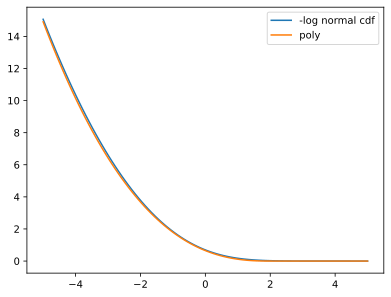

In [12]:
# Showing approximation of -log normal cdf
%matplotlib inline
from matplotlib import pyplot as plt
import scipy
import scipy.special
import numpy as np

def gaussian_cdf(x):
    return (1+scipy.special.erf(x/np.sqrt(2)))*0.5

X = np.linspace(-5,5,100)
Y = -np.log(gaussian_cdf(X))
plt.plot(X,Y,label="-log normal cdf")
plt.plot(X,0.115*np.maximum(0,-X+2)**2.5,label="poly")
plt.legend()
plt.show()